In [50]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math
import seaborn as sns
from collections import Counter

import matplotlib.ticker as plticker
from datetime import datetime


In [51]:
import sys

In [81]:
#attribute-specific mean, uncertainty, distribution
class Attribute:
    def __init__(self, m, std, a, ea, dist="normal"):
        self.mean = m
        self.std = std
        self.a = a #risk attitude
        self.ea = ea #estimation uncertainty
        
        if dist == "normal":
            self.value = np.random.normal(m, std)
        elif dist == "lognormal":
            self.value = np.random.lognormal(m, std)     
        
        self.U_f = U_f(self.a, self.std*(-3), self.std*3) #range set to include most of the randomly generated values
        
        self.ux = self.U_f.value(self.value)
        
        self.y = np.random.normal(self.value, self.ea)
        self.uy = self.U_f.value(self.y)
        
        s2 = self.std**2
        t2 = self.ea**2        
        m = (t2/(s2 + t2))*self.mean + (s2/(s2 + t2))*self.y
        std = np.sqrt((s2*t2/(s2 + t2)))
        
        #for right way 
        uz_l = []
        for k in range(1000):
            uz = self.U_f.value(np.random.normal(m, std))
            uz_l.append(uz)
        
        self.uz = np.mean(uz_l)
        
        #for wrong way 
        mean = np.mean(np.random.normal(m, std, 1000))
        self.uz2 = self.U_f.value(mean)
        
    def add_u(self, U): #add the attribute-specific utility function
        self.U_f = U
        self.a = U.a
    
    def describe(self, graph=False):
        print("Mean: ", self.mean)
        print("Std: ", self.std)
        print("Risk parameter a: ", self.a)
        print("Estimation uncertainty: ", self.ea)
        print("")
        print("Value: %.3f" %(self.value))
        print("ux: %.3f, uy: %.3f, uz: %.3f, uz3: %.2f" %(self.ux, self.uy, self.uz, self.uz2))
        
        if graph:
            print("Utility curve: ")
            self.U_f.graph()

In [88]:
a = Attribute(m=0, std=3, a=0.5, ea=5, dist="normal")

Mean:  0
Std:  3
Risk parameter a:  0.5
Estimation uncertainty:  5

Value: -2.879
ux: 0.953, uy: 0.781, uz: 0.944, uz3: 0.98
Utility curve: 


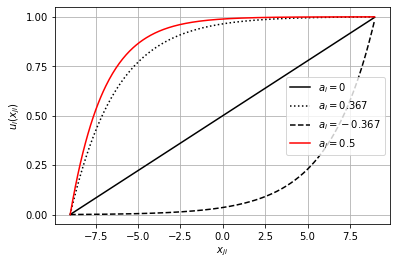

In [89]:
a.describe(True)

In [55]:
#attribute-specific utility function
class U_f:
    def __init__(self, a, x_min, x_max): #parameter: performance x, risk param a \in [-1,1],
        self.a = a
        #self.std = s 
        #self.x =x
        self.min = x_min
        self.max = x_max
        self.mean = (x_min+x_max)/2.0
        
    def value(self, x):
        if x <= self.min:
            return 0
        elif x >= self.max:
            return 1
        elif self.a == 0:
            return (1/(self.max-self.min))*(x-self.mean) + 0.5
        else:
            def b(z):
                return 1-math.e**(-self.a*z)
            
            if self.a >0:
                self.y_up = -b(self.min-self.mean)
            else:
                self.y_up = -b(self.mean-self.max)
                
            up = b(x-self.mean) + self.y_up
            down = (b(self.max-self.mean)-b(self.min-self.mean))  
            return up/down
        
    def graph(self):
        X = np.arange(self.min, self.max, 0.05)
        Y1 = [U_f(0.367, self.min, self.max).value(x) for x in X]
        Y2 = [U_f(-0.367, self.min, self.max).value(x) for x in X]
        Y3 = [U_f(0,self.min, self.max).value(x) for x in X] 
        Y4 = [U_f(self.a, self.min, self.max).value(x) for x in X]
        plt.plot(X,Y3, label=r'$a_i=0$', color='black') 
        plt.plot(X,Y1, label=r'$a_i=0.367$', color='black', linestyle='dotted') 
        plt.plot(X,Y2, label=r'$a_i=-0.367$', color='black', linestyle='dashed') 
        plt.plot(X,Y4, label=r'$a_i=$' + str(self.a), color='red') 
        #plt.axvline(0, color='k')
        #plt.axhline(0, color='k')
        plt.xlabel(r"$x_{ji}$")
        plt.ylabel(r"$u_i(x_{ji})$")

        plt.yticks(np.arange(0, 1.25, 0.25))

        plt.grid(which='major', axis='both', linestyle='-')
        plt.legend()
        plt.show()

In [56]:
class Alternative:
    def __init__(self, n=3):#number of attribute
        self.n = n
        self.w = [1/n]*n
        self.attr_l = [Attribute(m=0, std=1, a=0, ea=1) for i in range(n)] #original attribute
        
    def re_cal(self):
        self.x = []
        self.y = []
        self.z = []
        self.z2 = []
        
        for attr in self.attr_l:
            self.x.append(attr.ux) 
            self.y.append(attr.uy)
            self.z.append(attr.uz)
            self.z2.append(attr.uz2)
            
        self.x_val = np.dot(self.w, self.x)
        self.y_val = np.dot(self.w, self.y)
        self.z_val = np.dot(self.w, self.z)
        self.z2_val = np.dot(self.w, self.z2)
        
    def add_attributes(self, attr_l):
        self.attr_l = attr_l
        self.re_cal()
        
    def set_weight(self, w):
        self.w = w
        self.re_cal()
        
    def describe(self):
        self.re_cal()
        print("Number of attributes: ", self.n)
        def round_list(l):
            return [round(x,3) for x in l]
        print("Attribute weights: ", round_list(self.w))
        print("x: ", round_list(self.x))
        print("y: ", round_list(self.y))
        print("z: ", round_list(self.z))
        print("z2: ", round_list(self.z2))
        print("Ux: %.3f, Uy: %.3f, Uz: %.3f, Uz2: %.3f" % (self.x_val, self.y_val, self.z_val, self.z2_val))

In [57]:
A = Alternative()

In [58]:
A.describe()

Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.327, 0.558, 0.336]
y:  [0.311, 0.609, 0.338]
z:  [0.41, 0.554, 0.42]
z2:  [0.406, 0.559, 0.427]
Ux: 0.407, Uy: 0.419, Uz: 0.461, Uz2: 0.464


In [59]:
class Problem:
    def __init__(self, m=5, n=3): 
        self.m = m #number of alternatives
        self.n = n #number of attributes
        
        self.Alt_l = [Alternative(n=self.n) for i in range(self.m)]
        
    def re_cal(self):
        self.x_l = [alt.x_val for alt in self.Alt_l]
        self.y_l = [alt.y_val for alt in self.Alt_l]  
        self.z_l = [alt.z_val for alt in self.Alt_l]
        self.z2_l = [alt.z2_val for alt in self.Alt_l]
        
        self.max_x = max(self.x_l)
        self.max_y = max(self.y_l)
        self.max_z = max(self.z_l)
        self.max_z2 = max(self.z2_l)
        
        self.max_x_i = np.argmax(self.x_l)
        self.max_y_i = np.argmax(self.y_l)   
        self.max_z_i = np.argmax(self.z_l)
        self.max_z2_i = np.argmax(self.z2_l)
        
        self.pds_y = (self.x_l[self.max_y_i] - self.max_y)/self.max_y
        self.pds_z = (self.x_l[self.max_z_i] - self.max_z)/self.max_z
        self.pds_z2 = (self.x_l[self.max_z2_i] - self.max_z2)/self.max_z2
        
        self.eu_yz = self.x_l[self.max_y_i] - self.x_l[self.max_z_i]
        self.eu_yz2 = self.x_l[self.max_y_i] - self.x_l[self.max_z2_i]
        self.eu_zz2 = self.x_l[self.max_z2_i] - self.x_l[self.max_z_i]
        
    def set_parameters(self, w, a, mean, std, ea): #list for parameters for each attribute
        attr_l = []
        
        for j in range(self.m):
            print("Alternative ", str(j))
            print("")
            Alt = Alternative(self.n)
                 
            print("Attribute settings:")
            attr_l = []
            for i in range(self.n): #generate attributes
                attr = Attribute(m=mean[i], std=std[i], a=a[i], ea=ea[i], dist="normal")
                print("Attribute ", str(i))
                print(attr.describe())
                attr_l.append(attr)
                
            Alt.add_attributes(attr_l)
            Alt.set_weight(w)
            self.Alt_l[j] = Alt
            Alt.describe()
            print("")
        
        self.re_cal()
        
    def describe(self):
        self.re_cal()
        print("Number of alternatives: ", self.m)
        print("Number of attributes: ", self.n)
        for j in range(self.m):
            print("Alternative ", str(j+1))
            self.Alt_l[j].describe()
            print("")                 
            print("Attribute settings: ")
            for i in range(self.n): 
                print("Attribute ", str(i+1))
                print(self.Alt_l[j].attr_l[i].describe())                       
            print("") 
                
        def round_list(l):
            return [round(x,3) for x in l]       
        print("X of alternatives: ", round_list(self.x_l))
        print("Y of alternatives: ", round_list(self.y_l))
        print("Z of alternatives: ", round_list(self.z_l))
        print("Z2 of alternatives: ", round_list(self.z2_l))
        print("")
        print("Relative PDS of Y: ", self.pds_y)
        print("Relative PDS of Z: ", self.pds_z)
        print("Relative PDS of z2: ", self.pds_z2)
        print("")
        print("EU YZ: ", self.eu_yz)
        print("EU YZ2: ", self.eu_yz2)
        print("EU ZZ2: ", self.eu_zz2)

In [60]:
p = Problem(m=5, n=3)

Alternative  0

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0.367
Estimation uncertainty:  5
ux: 0.809, uy: 1.000, uz: 0.751, uz3: 0.77
Utility curve: 


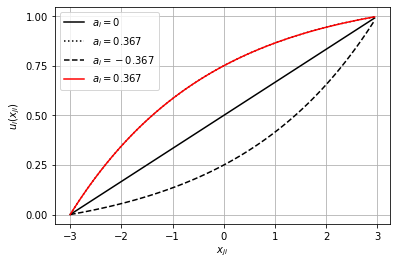

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.596, uy: 0.926, uz: 0.711, uz3: 0.71
Utility curve: 


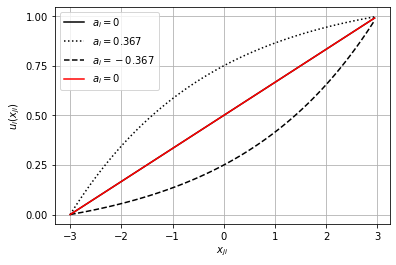

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.456, uy: 0.647, uz: 0.571, uz3: 0.57
Utility curve: 


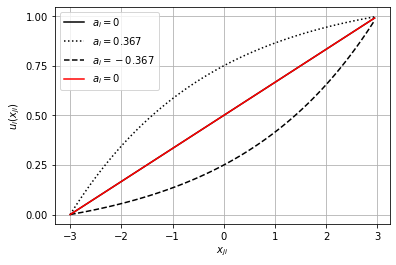

None
Number of attributes:  3
Attribute weights:  [0.5, 0.25, 0.25]
x:  [0.809, 0.596, 0.456]
y:  [1, 0.926, 0.647]
z:  [0.751, 0.711, 0.571]
z2:  [0.767, 0.712, 0.575]
Ux: 0.667, Uy: 0.893, Uz: 0.696, Uz2: 0.705

Alternative  1

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0.367
Estimation uncertainty:  5
ux: 0.712, uy: 1.000, uz: 0.744, uz3: 0.77
Utility curve: 


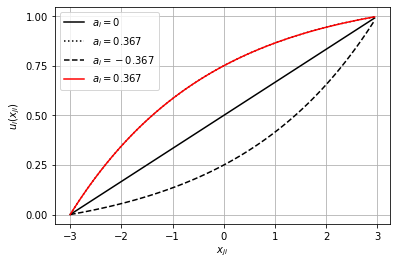

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.381, uy: 0.352, uz: 0.430, uz3: 0.43
Utility curve: 


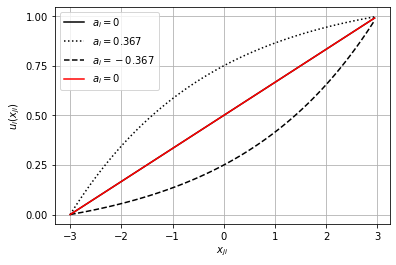

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.264, uy: 0.210, uz: 0.356, uz3: 0.35
Utility curve: 


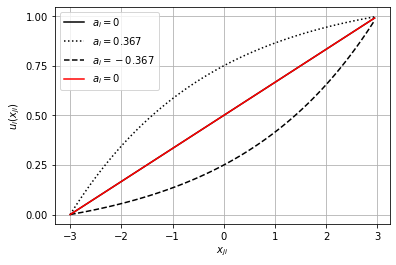

None
Number of attributes:  3
Attribute weights:  [0.5, 0.25, 0.25]
x:  [0.712, 0.381, 0.264]
y:  [1, 0.352, 0.21]
z:  [0.744, 0.43, 0.356]
z2:  [0.766, 0.427, 0.35]
Ux: 0.517, Uy: 0.641, Uz: 0.569, Uz2: 0.577

Alternative  2

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0.367
Estimation uncertainty:  5
ux: 0.637, uy: 0.000, uz: 0.664, uz3: 0.69
Utility curve: 


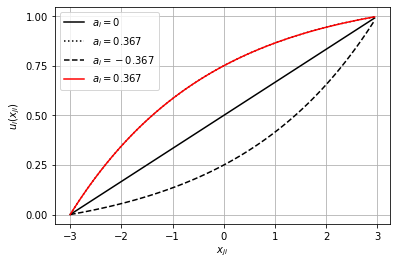

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.682, uy: 0.488, uz: 0.491, uz3: 0.50
Utility curve: 


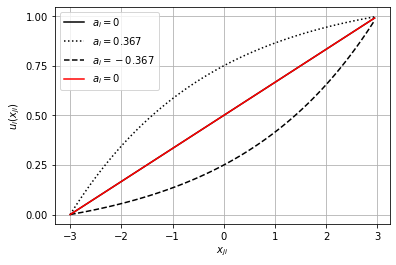

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.625, uy: 0.608, uz: 0.555, uz3: 0.56
Utility curve: 


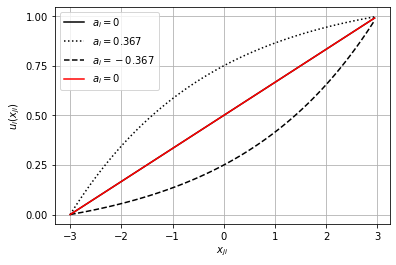

None
Number of attributes:  3
Attribute weights:  [0.5, 0.25, 0.25]
x:  [0.637, 0.682, 0.625]
y:  [0, 0.488, 0.608]
z:  [0.664, 0.491, 0.555]
z2:  [0.692, 0.497, 0.559]
Ux: 0.645, Uy: 0.274, Uz: 0.593, Uz2: 0.610

Alternative  3

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0.367
Estimation uncertainty:  5
ux: 0.656, uy: 0.002, uz: 0.711, uz3: 0.73
Utility curve: 


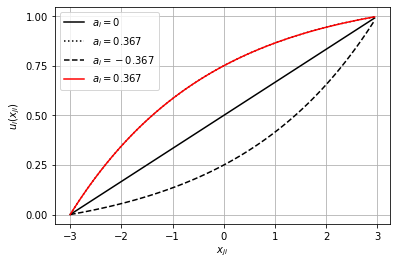

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.336, uy: 0.532, uz: 0.520, uz3: 0.52
Utility curve: 


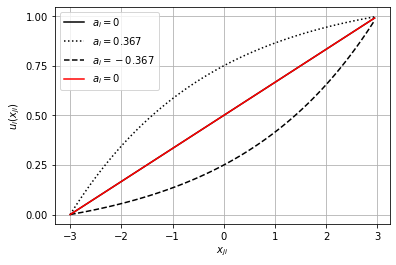

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.006, uy: 0.113, uz: 0.299, uz3: 0.30
Utility curve: 


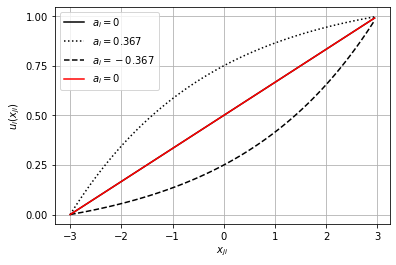

None
Number of attributes:  3
Attribute weights:  [0.5, 0.25, 0.25]
x:  [0.656, 0.336, 0.006]
y:  [0.002, 0.532, 0.113]
z:  [0.711, 0.52, 0.299]
z2:  [0.734, 0.521, 0.303]
Ux: 0.414, Uy: 0.162, Uz: 0.560, Uz2: 0.573

Alternative  4

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0.367
Estimation uncertainty:  5
ux: 0.935, uy: 0.000, uz: 0.692, uz3: 0.72
Utility curve: 


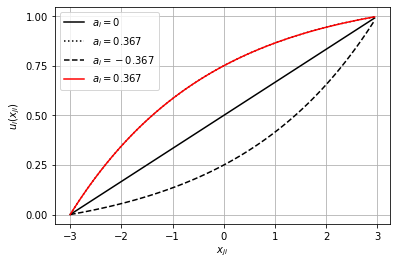

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.361, uy: 0.359, uz: 0.432, uz3: 0.43
Utility curve: 


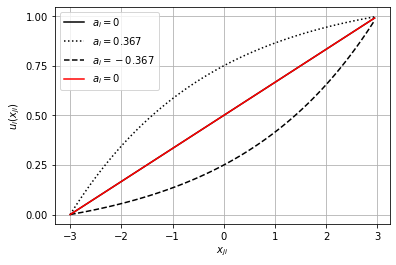

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.383, uy: 0.176, uz: 0.336, uz3: 0.34
Utility curve: 


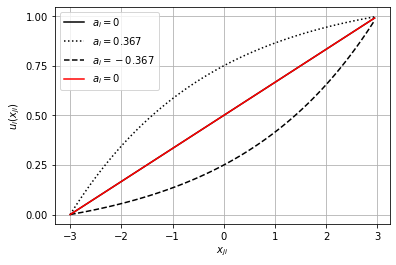

None
Number of attributes:  3
Attribute weights:  [0.5, 0.25, 0.25]
x:  [0.935, 0.361, 0.383]
y:  [0, 0.359, 0.176]
z:  [0.692, 0.432, 0.336]
z2:  [0.724, 0.429, 0.338]
Ux: 0.653, Uy: 0.134, Uz: 0.538, Uz2: 0.554



In [61]:
p.set_parameters([0.5, 0.25, 0.25], [0.367, 0,0], [0,0,0], [1,1,1], [5, 1, 1] )


Number of alternatives:  5
Number of attributes:  3
Alternative  1
Number of attributes:  3
Attribute weights:  [0.5, 0.25, 0.25]
x:  [0.809, 0.596, 0.456]
y:  [1, 0.926, 0.647]
z:  [0.751, 0.711, 0.571]
z2:  [0.767, 0.712, 0.575]
Ux: 0.667, Uy: 0.893, Uz: 0.696, Uz2: 0.705

Attribute settings: 
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0.367
Estimation uncertainty:  5
ux: 0.809, uy: 1.000, uz: 0.751, uz3: 0.77
Utility curve: 


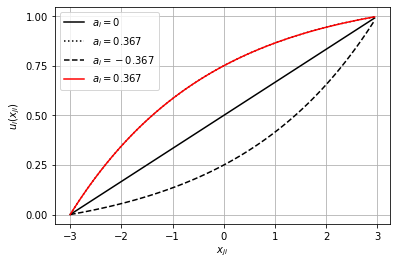

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.596, uy: 0.926, uz: 0.711, uz3: 0.71
Utility curve: 


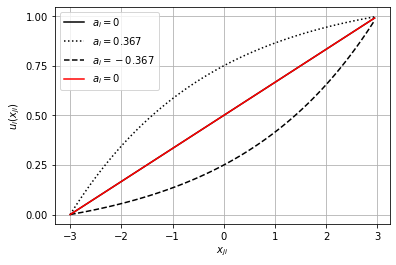

None
Attribute  3
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.456, uy: 0.647, uz: 0.571, uz3: 0.57
Utility curve: 


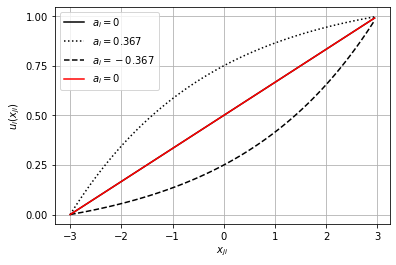

None

Alternative  2
Number of attributes:  3
Attribute weights:  [0.5, 0.25, 0.25]
x:  [0.712, 0.381, 0.264]
y:  [1, 0.352, 0.21]
z:  [0.744, 0.43, 0.356]
z2:  [0.766, 0.427, 0.35]
Ux: 0.517, Uy: 0.641, Uz: 0.569, Uz2: 0.577

Attribute settings: 
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0.367
Estimation uncertainty:  5
ux: 0.712, uy: 1.000, uz: 0.744, uz3: 0.77
Utility curve: 


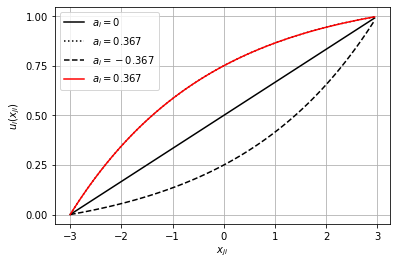

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.381, uy: 0.352, uz: 0.430, uz3: 0.43
Utility curve: 


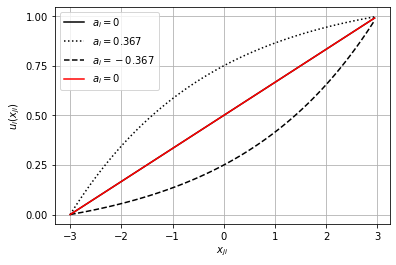

None
Attribute  3
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.264, uy: 0.210, uz: 0.356, uz3: 0.35
Utility curve: 


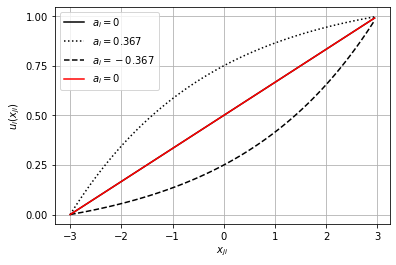

None

Alternative  3
Number of attributes:  3
Attribute weights:  [0.5, 0.25, 0.25]
x:  [0.637, 0.682, 0.625]
y:  [0, 0.488, 0.608]
z:  [0.664, 0.491, 0.555]
z2:  [0.692, 0.497, 0.559]
Ux: 0.645, Uy: 0.274, Uz: 0.593, Uz2: 0.610

Attribute settings: 
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0.367
Estimation uncertainty:  5
ux: 0.637, uy: 0.000, uz: 0.664, uz3: 0.69
Utility curve: 


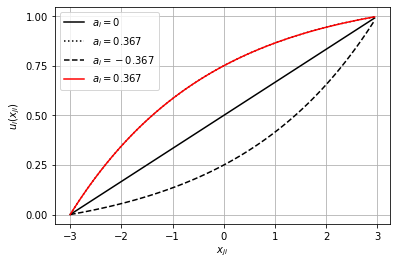

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.682, uy: 0.488, uz: 0.491, uz3: 0.50
Utility curve: 


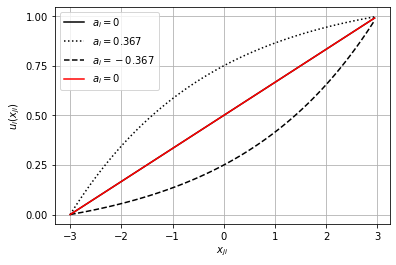

None
Attribute  3
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.625, uy: 0.608, uz: 0.555, uz3: 0.56
Utility curve: 


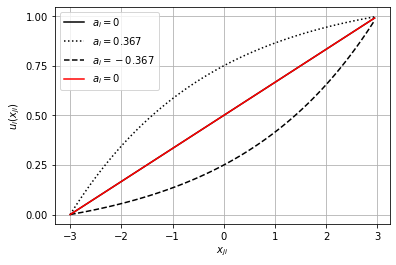

None

Alternative  4
Number of attributes:  3
Attribute weights:  [0.5, 0.25, 0.25]
x:  [0.656, 0.336, 0.006]
y:  [0.002, 0.532, 0.113]
z:  [0.711, 0.52, 0.299]
z2:  [0.734, 0.521, 0.303]
Ux: 0.414, Uy: 0.162, Uz: 0.560, Uz2: 0.573

Attribute settings: 
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0.367
Estimation uncertainty:  5
ux: 0.656, uy: 0.002, uz: 0.711, uz3: 0.73
Utility curve: 


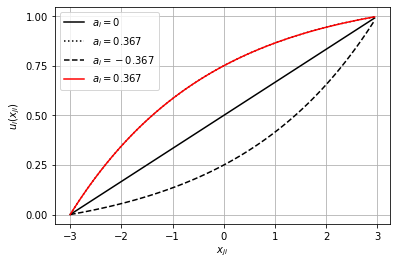

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.336, uy: 0.532, uz: 0.520, uz3: 0.52
Utility curve: 


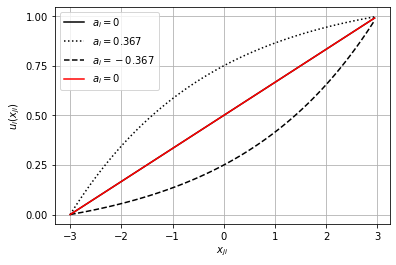

None
Attribute  3
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.006, uy: 0.113, uz: 0.299, uz3: 0.30
Utility curve: 


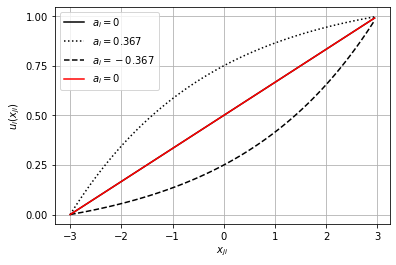

None

Alternative  5
Number of attributes:  3
Attribute weights:  [0.5, 0.25, 0.25]
x:  [0.935, 0.361, 0.383]
y:  [0, 0.359, 0.176]
z:  [0.692, 0.432, 0.336]
z2:  [0.724, 0.429, 0.338]
Ux: 0.653, Uy: 0.134, Uz: 0.538, Uz2: 0.554

Attribute settings: 
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0.367
Estimation uncertainty:  5
ux: 0.935, uy: 0.000, uz: 0.692, uz3: 0.72
Utility curve: 


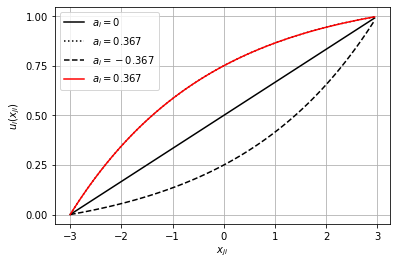

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.361, uy: 0.359, uz: 0.432, uz3: 0.43
Utility curve: 


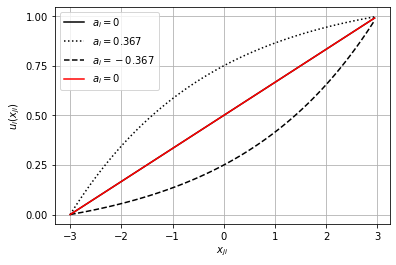

None
Attribute  3
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.383, uy: 0.176, uz: 0.336, uz3: 0.34
Utility curve: 


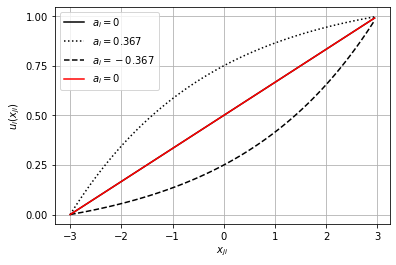

None

X of alternatives:  [0.667, 0.517, 0.645, 0.414, 0.653]
Y of alternatives:  [0.893, 0.641, 0.274, 0.162, 0.134]
Z of alternatives:  [0.696, 0.569, 0.593, 0.56, 0.538]
Z2 of alternatives:  [0.705, 0.577, 0.61, 0.573, 0.554]

Relative PDS of Y:  -0.25323041497455606
Relative PDS of Z:  -0.04154280949047819
Relative PDS of z2:  -0.05366850549113811

EU YZ:  0.0
EU YZ2:  0.0
EU ZZ2:  0.0


In [62]:
p.describe()

In [63]:
class Simulation:
    def __init__(self,  n_alt=5, n_attr=3, w=[1/3, 1/3, 1/3], a= [0,0,0], mean= [0,0,0], std=[1,1,1], ea=[1,1,1]):
        self.pds_y = []
        self.pds_z = []
        self.pds_z2 = []
        
        self.eu_yz = []
        self.eu_yz2 = []
        self.eu_zz2 = []
        
        self.toc_y = []
        self.toc_z = []
        self.toc_z2 = []
        
        self.m = n_alt
        self.n = n_attr
        
        self.w = w
        self.a = a
        self.mean= mean
        self.std = std
        self.ea = ea
        
        self.p = Problem(m=self.m, n=self.n)
        self.p.set_parameters(w=self.w, a=self.a, mean=self.mean, std=self.std, ea=self.ea)
        self.p.describe()
        
    def run(self, rep=10000):
        
        start_time = datetime.now()
       
        for i in range(rep):
    
            p = Problem(m=self.m, n=self.n)
            p.set_parameters(w=self.w, a=self.a, mean=self.mean, std=self.std, ea=self.ea)

            self.pds_y.append(p.pds_y)
            self.pds_z.append(p.pds_z)
            self.pds_z2.append(p.pds_z2)
            
            self.eu_yz.append(p.eu_yz)
            self.eu_yz2.append(p.eu_yz2)
            self.eu_zz2.append(p.eu_zz2)
            
            self.toc_y.append(p.max_x_i == p.max_y_i)
            self.toc_z.append(p.max_x_i == p.max_z_i)
            self.toc_z2.append(p.max_x_i == p.max_z2_i)
            
        end_time = datetime.now()
        print('Duration: {}'.format(end_time - start_time))
        
    def save_output(self, filename):
        d = {}
        d["pds_y"] = self.pds_y
        d["pds_z"] = self.pds_z
        d["pds_z2"] = self.pds_z2
        d["eu_yz"] = self.eu_yz
        d["eu_yz2"] = self.eu_yz2
        d["eu_zz2"] = self.eu_zz2
        d["toc_y"] = self.toc_y
        d["toc_z"] = self.toc_z
        d["toc_z2"] = self.toc_z2
        
        df = pd.DataFrame(d)
        df.to_csv(filename + ".csv")

        orig_stdout = sys.stdout
        f = open(filename + '.txt', 'w')
        sys.stdout = f
        
        self.p.describe()

        sys.stdout = orig_stdout
        f.close()
        

Alternative  0

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.519, uy: 0.634, uz: 0.563, uz3: 0.57
Utility curve: 


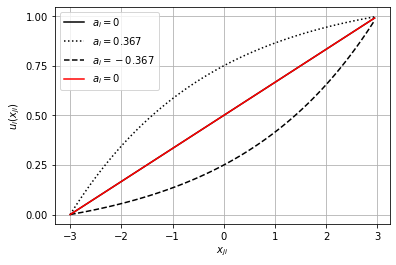

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.348, uy: 0.882, uz: 0.692, uz3: 0.69
Utility curve: 


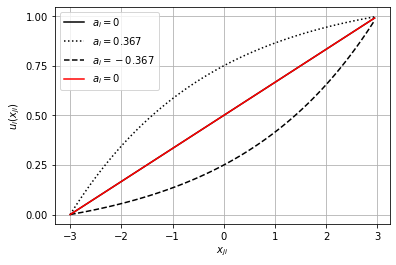

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.596, uy: 0.884, uz: 0.695, uz3: 0.69
Utility curve: 


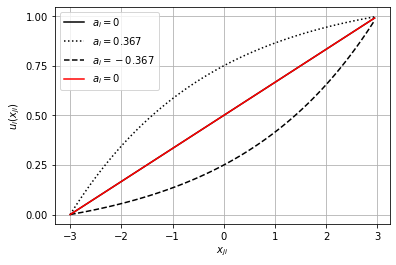

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.519, 0.348, 0.596]
y:  [0.634, 0.882, 0.884]
z:  [0.563, 0.692, 0.695]
z2:  [0.568, 0.689, 0.69]
Ux: 0.488, Uy: 0.800, Uz: 0.650, Uz2: 0.649

Alternative  1

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.665, uy: 0.589, uz: 0.547, uz3: 0.55
Utility curve: 


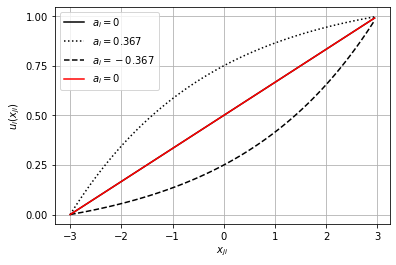

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.637, uy: 0.767, uz: 0.636, uz3: 0.64
Utility curve: 


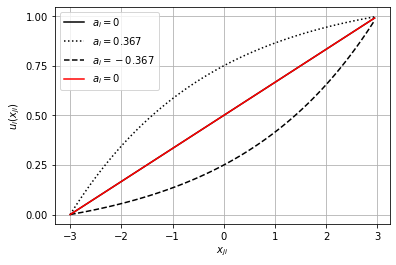

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.375, uy: 0.440, uz: 0.467, uz3: 0.47
Utility curve: 


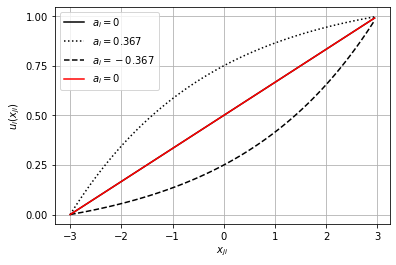

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.665, 0.637, 0.375]
y:  [0.589, 0.767, 0.44]
z:  [0.547, 0.636, 0.467]
z2:  [0.55, 0.637, 0.473]
Ux: 0.559, Uy: 0.599, Uz: 0.550, Uz2: 0.553

Alternative  2

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.497, uy: 0.297, uz: 0.399, uz3: 0.40
Utility curve: 


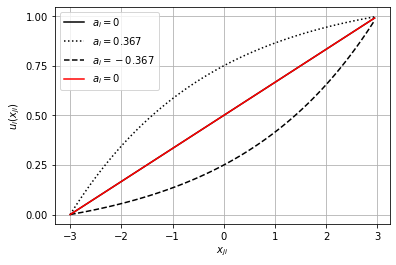

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.267, uy: 0.305, uz: 0.405, uz3: 0.40
Utility curve: 


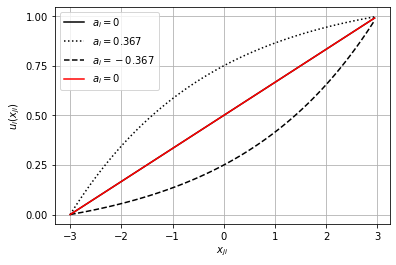

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.564, uy: 0.459, uz: 0.480, uz3: 0.47
Utility curve: 


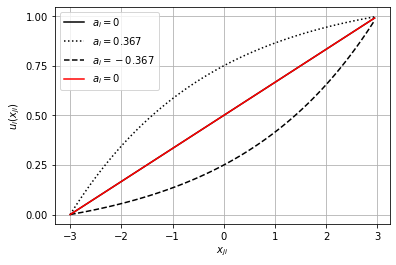

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.497, 0.267, 0.564]
y:  [0.297, 0.305, 0.459]
z:  [0.399, 0.405, 0.48]
z2:  [0.398, 0.404, 0.473]
Ux: 0.443, Uy: 0.353, Uz: 0.428, Uz2: 0.425

Alternative  3

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.429, uy: 0.296, uz: 0.395, uz3: 0.40
Utility curve: 


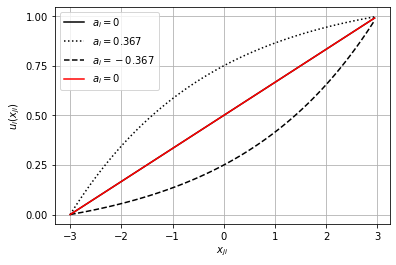

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.335, uy: 0.406, uz: 0.453, uz3: 0.46
Utility curve: 


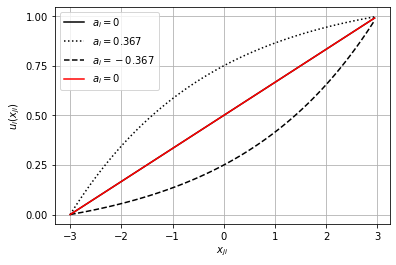

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.456, uy: 0.633, uz: 0.562, uz3: 0.56
Utility curve: 


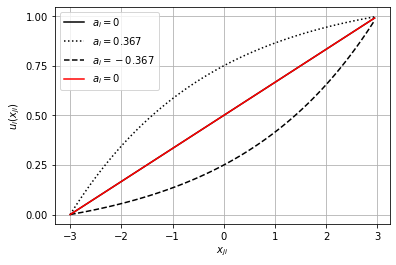

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.429, 0.335, 0.456]
y:  [0.296, 0.406, 0.633]
z:  [0.395, 0.453, 0.562]
z2:  [0.403, 0.459, 0.562]
Ux: 0.406, Uy: 0.445, Uz: 0.470, Uz2: 0.475

Alternative  4

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.521, uy: 0.343, uz: 0.415, uz3: 0.42
Utility curve: 


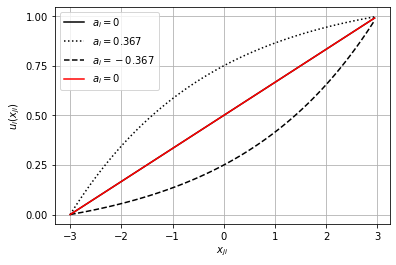

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.643, uy: 0.734, uz: 0.617, uz3: 0.62
Utility curve: 


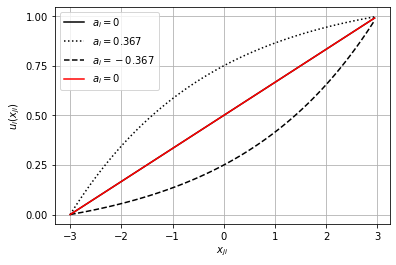

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.657, uy: 0.635, uz: 0.563, uz3: 0.58
Utility curve: 


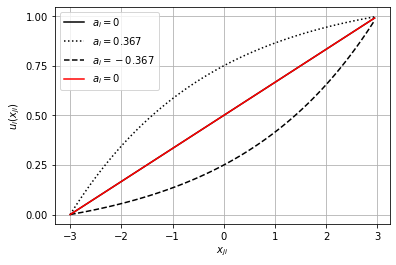

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.521, 0.643, 0.657]
y:  [0.343, 0.734, 0.635]
z:  [0.415, 0.617, 0.563]
z2:  [0.424, 0.617, 0.576]
Ux: 0.607, Uy: 0.571, Uz: 0.532, Uz2: 0.539

Number of alternatives:  5
Number of attributes:  3
Alternative  1
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.519, 0.348, 0.596]
y:  [0.634, 0.882, 0.884]
z:  [0.563, 0.692, 0.695]
z2:  [0.568, 0.689, 0.69]
Ux: 0.488, Uy: 0.800, Uz: 0.650, Uz2: 0.649

Attribute settings: 
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.519, uy: 0.634, uz: 0.563, uz3: 0.57
Utility curve: 


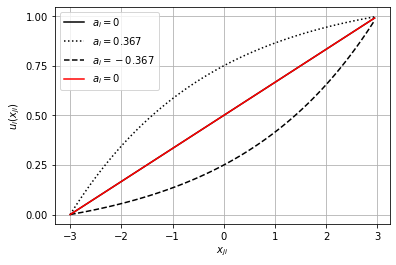

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.348, uy: 0.882, uz: 0.692, uz3: 0.69
Utility curve: 


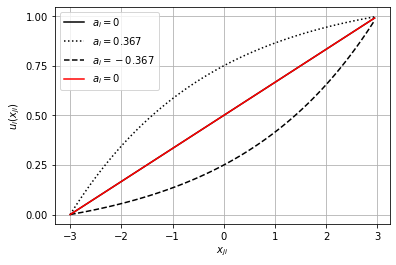

None
Attribute  3
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.596, uy: 0.884, uz: 0.695, uz3: 0.69
Utility curve: 


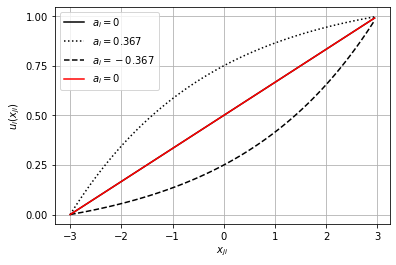

None

Alternative  2
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.665, 0.637, 0.375]
y:  [0.589, 0.767, 0.44]
z:  [0.547, 0.636, 0.467]
z2:  [0.55, 0.637, 0.473]
Ux: 0.559, Uy: 0.599, Uz: 0.550, Uz2: 0.553

Attribute settings: 
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.665, uy: 0.589, uz: 0.547, uz3: 0.55
Utility curve: 


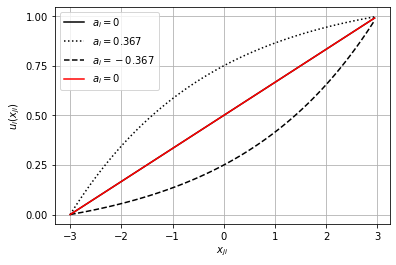

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.637, uy: 0.767, uz: 0.636, uz3: 0.64
Utility curve: 


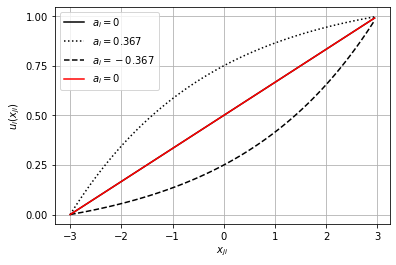

None
Attribute  3
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.375, uy: 0.440, uz: 0.467, uz3: 0.47
Utility curve: 


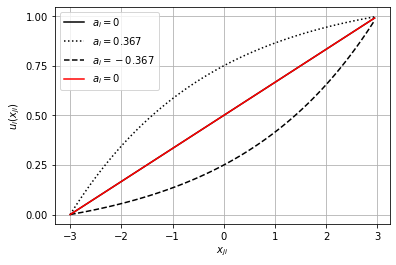

None

Alternative  3
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.497, 0.267, 0.564]
y:  [0.297, 0.305, 0.459]
z:  [0.399, 0.405, 0.48]
z2:  [0.398, 0.404, 0.473]
Ux: 0.443, Uy: 0.353, Uz: 0.428, Uz2: 0.425

Attribute settings: 
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.497, uy: 0.297, uz: 0.399, uz3: 0.40
Utility curve: 


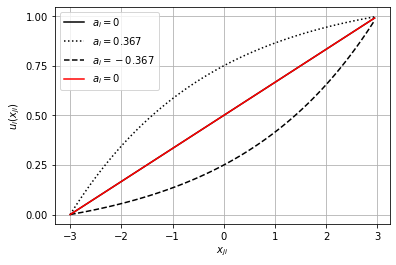

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.267, uy: 0.305, uz: 0.405, uz3: 0.40
Utility curve: 


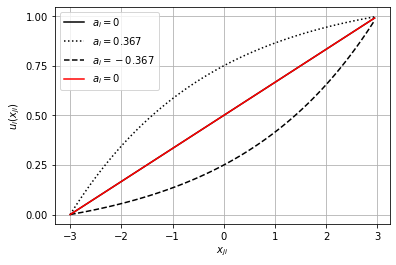

None
Attribute  3
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.564, uy: 0.459, uz: 0.480, uz3: 0.47
Utility curve: 


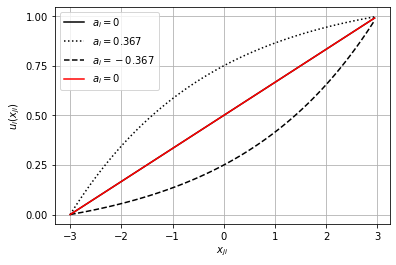

None

Alternative  4
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.429, 0.335, 0.456]
y:  [0.296, 0.406, 0.633]
z:  [0.395, 0.453, 0.562]
z2:  [0.403, 0.459, 0.562]
Ux: 0.406, Uy: 0.445, Uz: 0.470, Uz2: 0.475

Attribute settings: 
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.429, uy: 0.296, uz: 0.395, uz3: 0.40
Utility curve: 


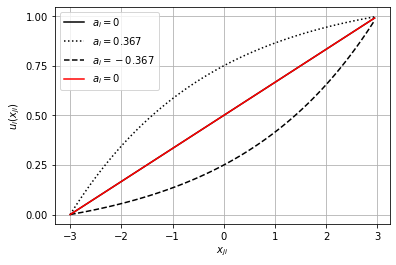

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.335, uy: 0.406, uz: 0.453, uz3: 0.46
Utility curve: 


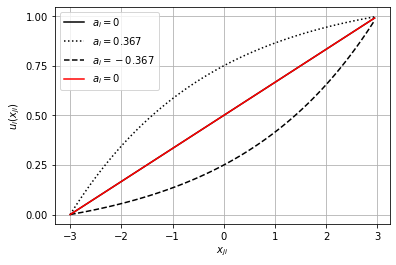

None
Attribute  3
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.456, uy: 0.633, uz: 0.562, uz3: 0.56
Utility curve: 


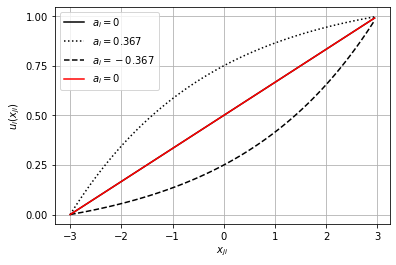

None

Alternative  5
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.521, 0.643, 0.657]
y:  [0.343, 0.734, 0.635]
z:  [0.415, 0.617, 0.563]
z2:  [0.424, 0.617, 0.576]
Ux: 0.607, Uy: 0.571, Uz: 0.532, Uz2: 0.539

Attribute settings: 
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.521, uy: 0.343, uz: 0.415, uz3: 0.42
Utility curve: 


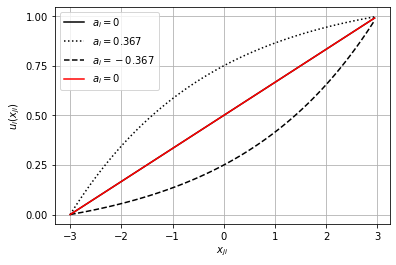

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.643, uy: 0.734, uz: 0.617, uz3: 0.62
Utility curve: 


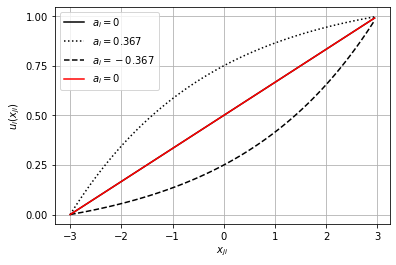

None
Attribute  3
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.657, uy: 0.635, uz: 0.563, uz3: 0.58
Utility curve: 


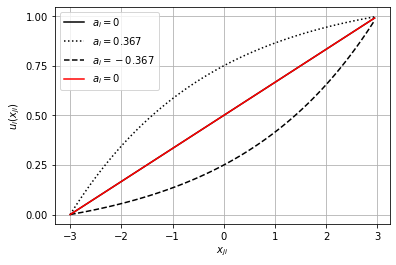

None

X of alternatives:  [0.488, 0.559, 0.443, 0.406, 0.607]
Y of alternatives:  [0.8, 0.599, 0.353, 0.445, 0.571]
Z of alternatives:  [0.65, 0.55, 0.428, 0.47, 0.532]
Z2 of alternatives:  [0.649, 0.553, 0.425, 0.475, 0.539]

Relative PDS of Y:  -0.39042414990223584
Relative PDS of Z:  -0.24990029378982292
Relative PDS of z2:  -0.24879569072622382

EU YZ:  0.0
EU YZ2:  0.0
EU ZZ2:  0.0


In [64]:
s = Simulation()

Alternative  0

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.358, uy: 0.238, uz: 0.365, uz3: 0.37
Utility curve: 


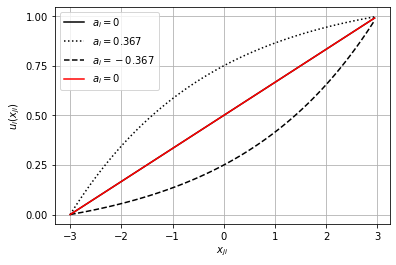

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.684, uy: 0.644, uz: 0.573, uz3: 0.57
Utility curve: 


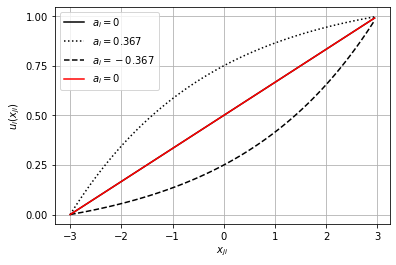

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.681, uy: 0.710, uz: 0.608, uz3: 0.60
Utility curve: 


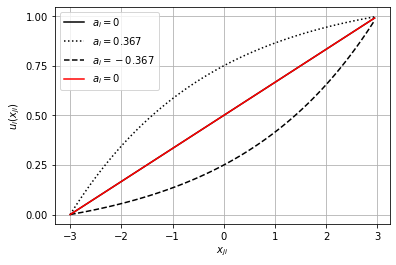

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.358, 0.684, 0.681]
y:  [0.238, 0.644, 0.71]
z:  [0.365, 0.573, 0.608]
z2:  [0.366, 0.568, 0.604]
Ux: 0.574, Uy: 0.531, Uz: 0.515, Uz2: 0.513

Alternative  1

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.335, uy: 0.604, uz: 0.551, uz3: 0.54
Utility curve: 


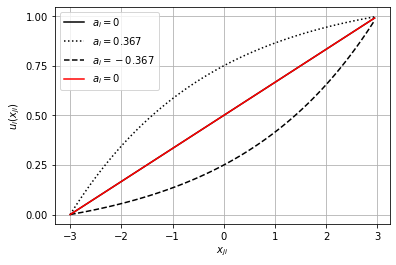

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.278, uy: 0.350, uz: 0.428, uz3: 0.42
Utility curve: 


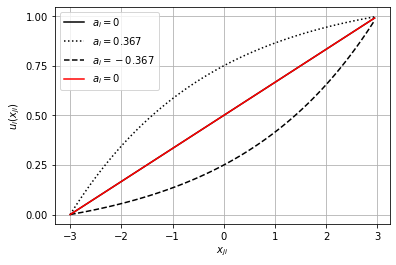

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.845, uy: 0.650, uz: 0.577, uz3: 0.58
Utility curve: 


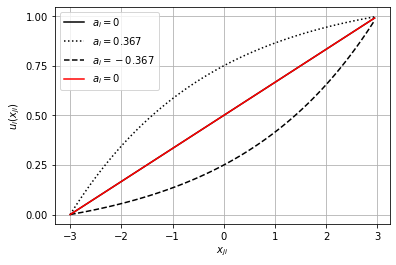

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.335, 0.278, 0.845]
y:  [0.604, 0.35, 0.65]
z:  [0.551, 0.428, 0.577]
z2:  [0.544, 0.419, 0.58]
Ux: 0.486, Uy: 0.535, Uz: 0.519, Uz2: 0.514

Alternative  2

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.610, uy: 0.701, uz: 0.596, uz3: 0.60
Utility curve: 


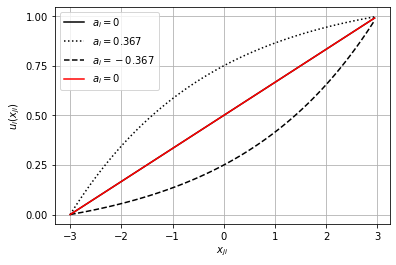

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.364, uy: 0.355, uz: 0.429, uz3: 0.44
Utility curve: 


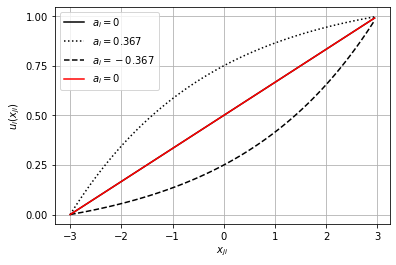

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.433, uy: 0.149, uz: 0.328, uz3: 0.32
Utility curve: 


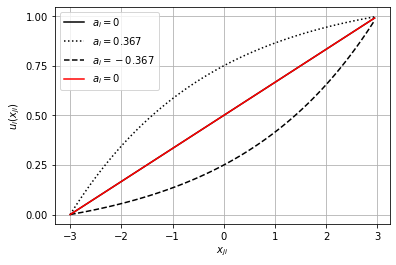

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.61, 0.364, 0.433]
y:  [0.701, 0.355, 0.149]
z:  [0.596, 0.429, 0.328]
z2:  [0.601, 0.437, 0.32]
Ux: 0.469, Uy: 0.402, Uz: 0.451, Uz2: 0.453

Alternative  3

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.701, uy: 0.810, uz: 0.657, uz3: 0.65
Utility curve: 


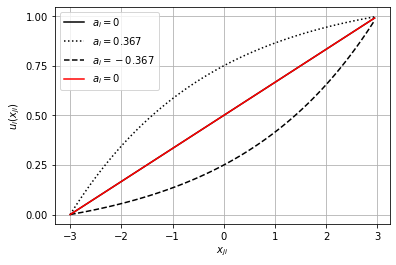

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.762, uy: 0.542, uz: 0.515, uz3: 0.52
Utility curve: 


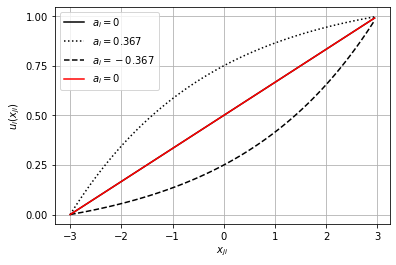

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.272, uy: 0.514, uz: 0.507, uz3: 0.51
Utility curve: 


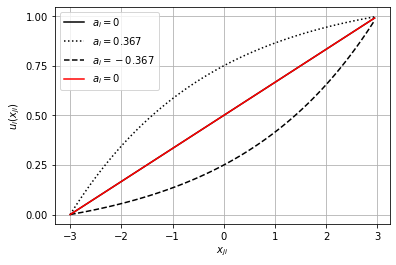

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.701, 0.762, 0.272]
y:  [0.81, 0.542, 0.514]
z:  [0.657, 0.515, 0.507]
z2:  [0.652, 0.519, 0.507]
Ux: 0.578, Uy: 0.622, Uz: 0.560, Uz2: 0.559

Alternative  4

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.657, uy: 0.829, uz: 0.671, uz3: 0.66
Utility curve: 


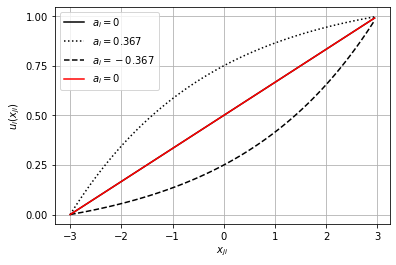

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.520, uy: 0.551, uz: 0.521, uz3: 0.53
Utility curve: 


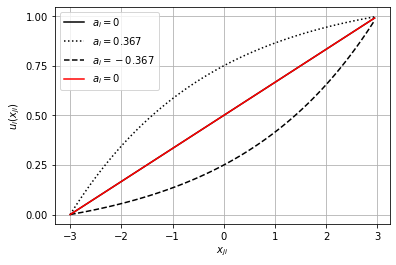

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.630, uy: 0.659, uz: 0.577, uz3: 0.57
Utility curve: 


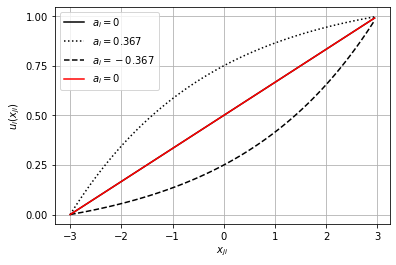

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.657, 0.52, 0.63]
y:  [0.829, 0.551, 0.659]
z:  [0.671, 0.521, 0.577]
z2:  [0.66, 0.526, 0.573]
Ux: 0.602, Uy: 0.680, Uz: 0.590, Uz2: 0.586

Alternative  0

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.476, uy: 0.614, uz: 0.558, uz3: 0.56
Utility curve: 


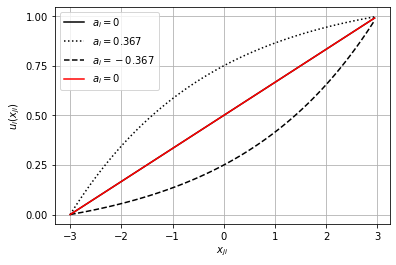

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.429, uy: 0.494, uz: 0.494, uz3: 0.50
Utility curve: 


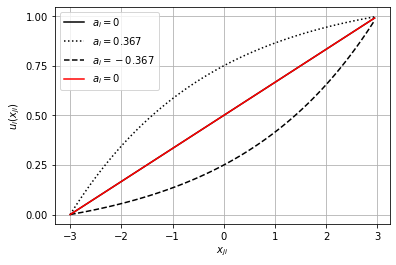

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.319, uy: 0.186, uz: 0.339, uz3: 0.34
Utility curve: 


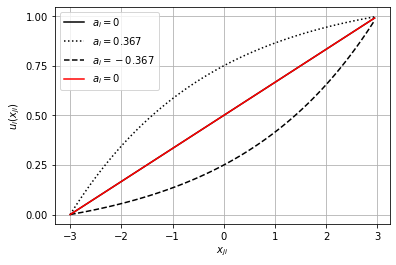

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.476, 0.429, 0.319]
y:  [0.614, 0.494, 0.186]
z:  [0.558, 0.494, 0.339]
z2:  [0.557, 0.499, 0.344]
Ux: 0.408, Uy: 0.431, Uz: 0.464, Uz2: 0.467

Alternative  1

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.514, uy: 0.308, uz: 0.407, uz3: 0.40
Utility curve: 


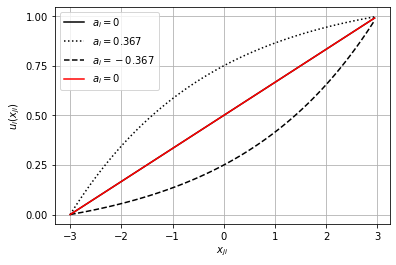

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.294, uy: 0.403, uz: 0.450, uz3: 0.45
Utility curve: 


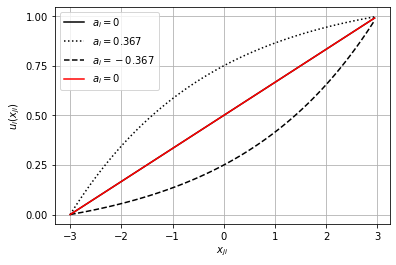

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.664, uy: 0.766, uz: 0.635, uz3: 0.64
Utility curve: 


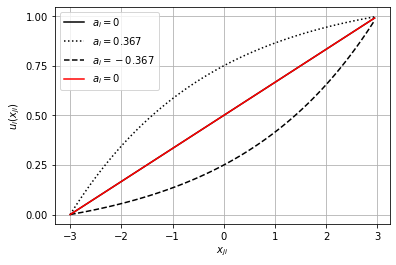

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.514, 0.294, 0.664]
y:  [0.308, 0.403, 0.766]
z:  [0.407, 0.45, 0.635]
z2:  [0.4, 0.455, 0.637]
Ux: 0.491, Uy: 0.492, Uz: 0.498, Uz2: 0.497

Alternative  2

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.504, uy: 0.462, uz: 0.478, uz3: 0.48
Utility curve: 


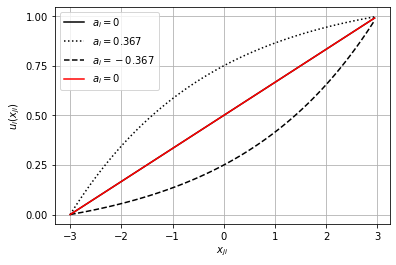

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.810, uy: 0.763, uz: 0.628, uz3: 0.63
Utility curve: 


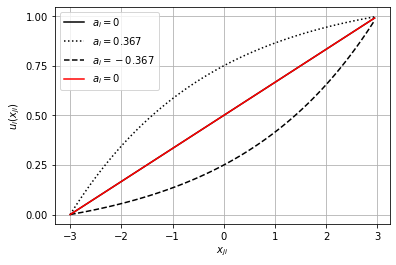

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.332, uy: 0.402, uz: 0.451, uz3: 0.45
Utility curve: 


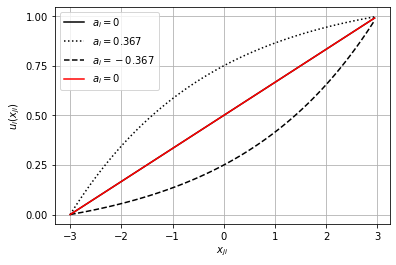

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.504, 0.81, 0.332]
y:  [0.462, 0.763, 0.402]
z:  [0.478, 0.628, 0.451]
z2:  [0.483, 0.628, 0.453]
Ux: 0.549, Uy: 0.542, Uz: 0.519, Uz2: 0.521

Alternative  3

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.420, uy: 0.568, uz: 0.529, uz3: 0.54
Utility curve: 


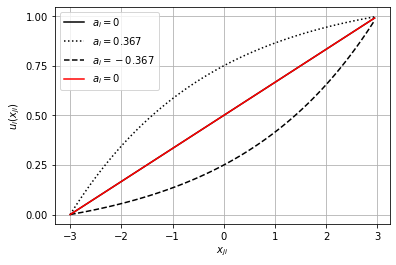

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.393, uy: 0.378, uz: 0.442, uz3: 0.43
Utility curve: 


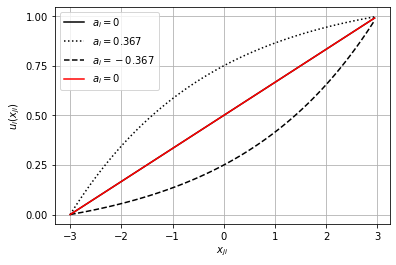

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.684, uy: 0.810, uz: 0.654, uz3: 0.66
Utility curve: 


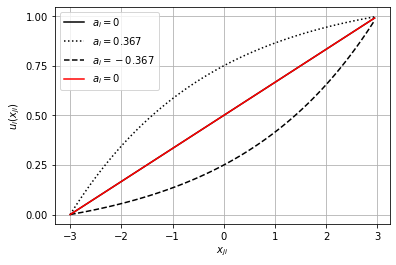

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.42, 0.393, 0.684]
y:  [0.568, 0.378, 0.81]
z:  [0.529, 0.442, 0.654]
z2:  [0.537, 0.433, 0.658]
Ux: 0.499, Uy: 0.585, Uz: 0.542, Uz2: 0.543

Alternative  4

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.436, uy: 0.470, uz: 0.483, uz3: 0.48
Utility curve: 


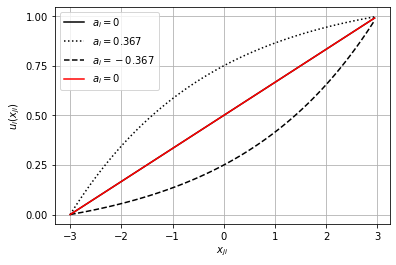

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.842, uy: 0.867, uz: 0.683, uz3: 0.68
Utility curve: 


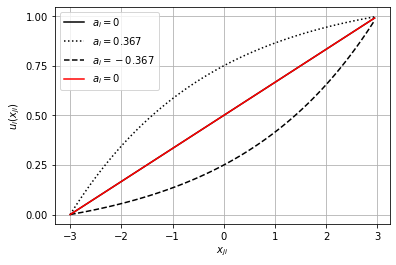

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.409, uy: 0.407, uz: 0.451, uz3: 0.45
Utility curve: 


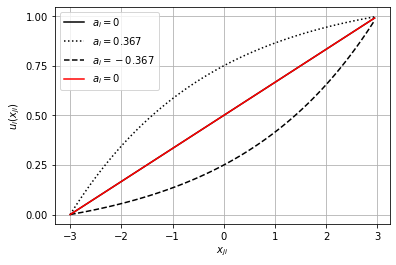

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.436, 0.842, 0.409]
y:  [0.47, 0.867, 0.407]
z:  [0.483, 0.683, 0.451]
z2:  [0.485, 0.683, 0.45]
Ux: 0.563, Uy: 0.581, Uz: 0.539, Uz2: 0.539

Alternative  0

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.354, uy: 0.718, uz: 0.606, uz3: 0.62
Utility curve: 


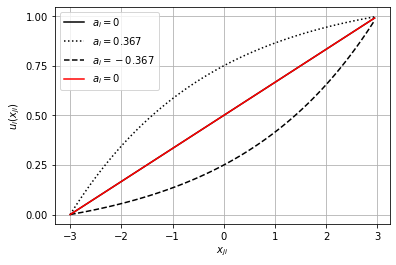

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.375, uy: 0.388, uz: 0.444, uz3: 0.44
Utility curve: 


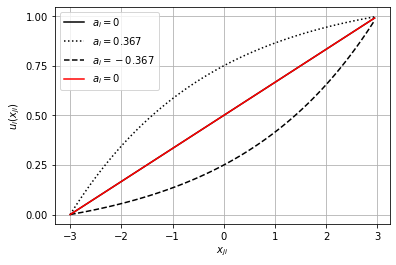

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.275, uy: 0.255, uz: 0.379, uz3: 0.38
Utility curve: 


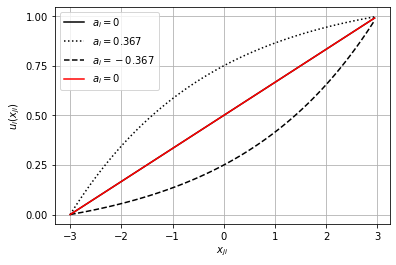

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.354, 0.375, 0.275]
y:  [0.718, 0.388, 0.255]
z:  [0.606, 0.444, 0.379]
z2:  [0.619, 0.441, 0.377]
Ux: 0.335, Uy: 0.454, Uz: 0.476, Uz2: 0.479

Alternative  1

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.365, uy: 0.085, uz: 0.299, uz3: 0.29
Utility curve: 


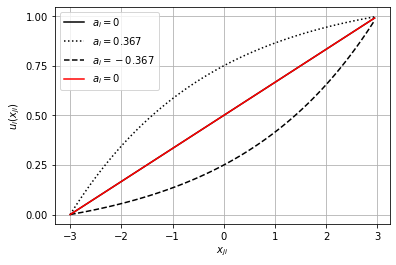

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.472, uy: 0.698, uz: 0.596, uz3: 0.60
Utility curve: 


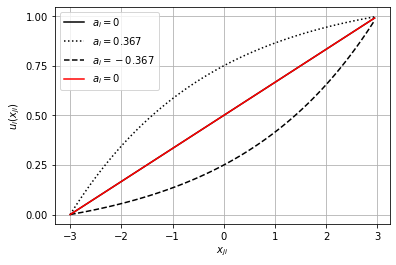

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.563, uy: 0.588, uz: 0.552, uz3: 0.54
Utility curve: 


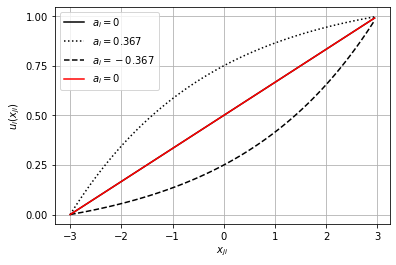

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.365, 0.472, 0.563]
y:  [0.085, 0.698, 0.588]
z:  [0.299, 0.596, 0.552]
z2:  [0.292, 0.604, 0.541]
Ux: 0.467, Uy: 0.457, Uz: 0.482, Uz2: 0.479

Alternative  2

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.468, uy: 0.517, uz: 0.509, uz3: 0.51
Utility curve: 


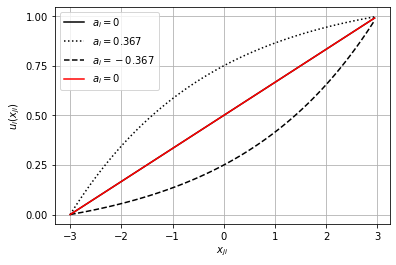

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.611, uy: 0.545, uz: 0.522, uz3: 0.52
Utility curve: 


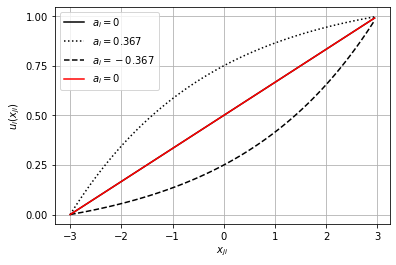

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.646, uy: 0.955, uz: 0.727, uz3: 0.72
Utility curve: 


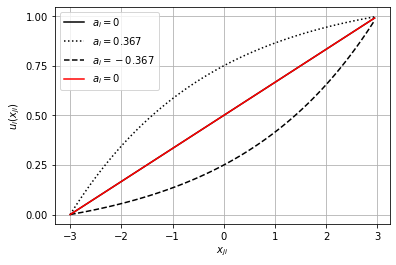

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.468, 0.611, 0.646]
y:  [0.517, 0.545, 0.955]
z:  [0.509, 0.522, 0.727]
z2:  [0.508, 0.523, 0.72]
Ux: 0.575, Uy: 0.672, Uz: 0.586, Uz2: 0.584

Alternative  3

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.450, uy: 0.272, uz: 0.391, uz3: 0.39
Utility curve: 


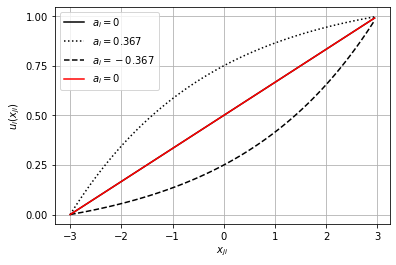

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.388, uy: 0.394, uz: 0.443, uz3: 0.45
Utility curve: 


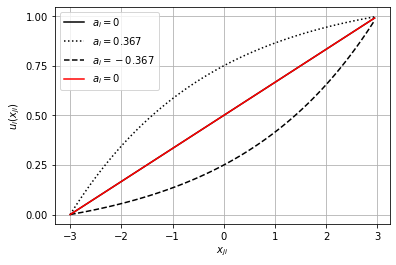

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.395, uy: 0.538, uz: 0.510, uz3: 0.52
Utility curve: 


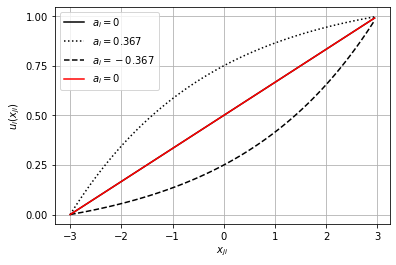

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.45, 0.388, 0.395]
y:  [0.272, 0.394, 0.538]
z:  [0.391, 0.443, 0.51]
z2:  [0.387, 0.447, 0.523]
Ux: 0.411, Uy: 0.401, Uz: 0.448, Uz2: 0.452

Alternative  4

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.396, uy: 0.239, uz: 0.365, uz3: 0.37
Utility curve: 


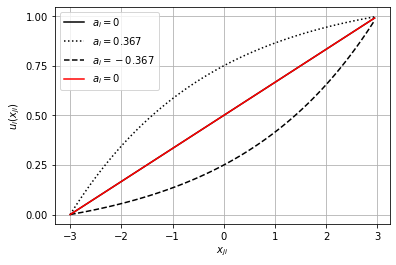

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.131, uy: 0.059, uz: 0.281, uz3: 0.28
Utility curve: 


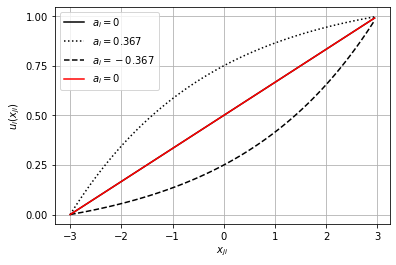

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.261, uy: 0.072, uz: 0.290, uz3: 0.29
Utility curve: 


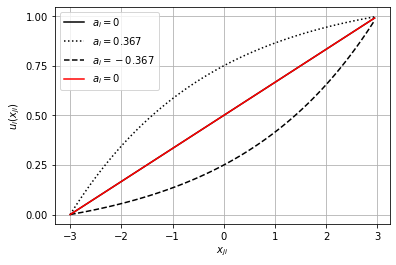

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.396, 0.131, 0.261]
y:  [0.239, 0.059, 0.072]
z:  [0.365, 0.281, 0.29]
z2:  [0.368, 0.281, 0.285]
Ux: 0.262, Uy: 0.124, Uz: 0.312, Uz2: 0.311

Alternative  0

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.271, uy: 0.446, uz: 0.473, uz3: 0.48
Utility curve: 


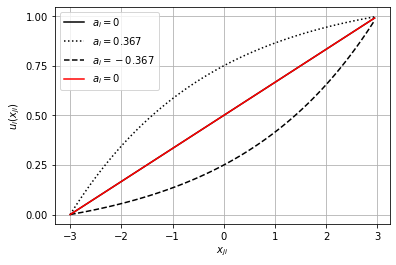

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.433, uy: 0.445, uz: 0.467, uz3: 0.48
Utility curve: 


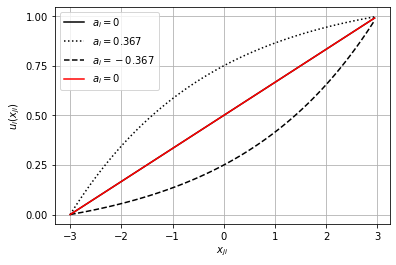

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.246, uy: 0.393, uz: 0.449, uz3: 0.45
Utility curve: 


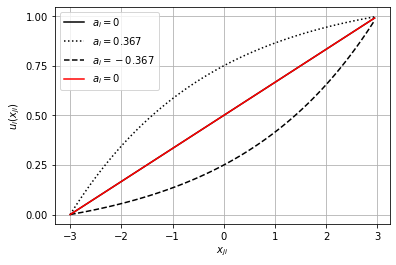

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.271, 0.433, 0.246]
y:  [0.446, 0.445, 0.393]
z:  [0.473, 0.467, 0.449]
z2:  [0.484, 0.477, 0.448]
Ux: 0.317, Uy: 0.428, Uz: 0.463, Uz2: 0.470

Alternative  1

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.519, uy: 0.544, uz: 0.514, uz3: 0.52
Utility curve: 


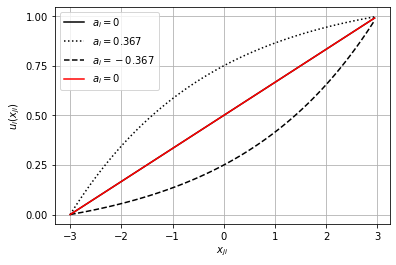

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.775, uy: 0.695, uz: 0.601, uz3: 0.60
Utility curve: 


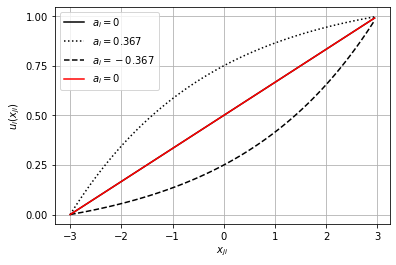

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.601, uy: 0.390, uz: 0.447, uz3: 0.44
Utility curve: 


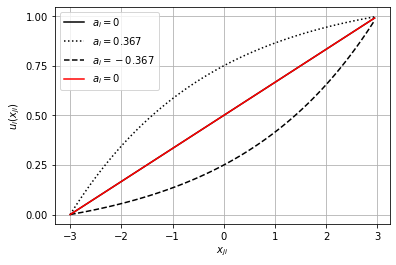

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.519, 0.775, 0.601]
y:  [0.544, 0.695, 0.39]
z:  [0.514, 0.601, 0.447]
z2:  [0.515, 0.597, 0.444]
Ux: 0.632, Uy: 0.543, Uz: 0.521, Uz2: 0.519

Alternative  2

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.391, uy: 0.523, uz: 0.516, uz3: 0.51
Utility curve: 


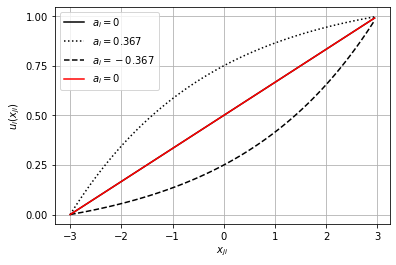

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.257, uy: 0.117, uz: 0.313, uz3: 0.31
Utility curve: 


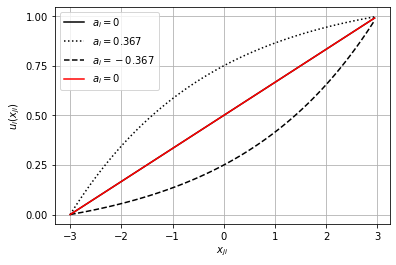

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.606, uy: 0.945, uz: 0.720, uz3: 0.72
Utility curve: 


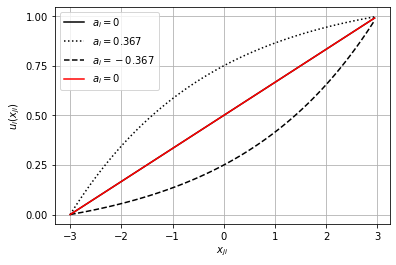

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.391, 0.257, 0.606]
y:  [0.523, 0.117, 0.945]
z:  [0.516, 0.313, 0.72]
z2:  [0.51, 0.311, 0.721]
Ux: 0.418, Uy: 0.528, Uz: 0.517, Uz2: 0.514

Alternative  3

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.613, uy: 0.672, uz: 0.584, uz3: 0.58
Utility curve: 


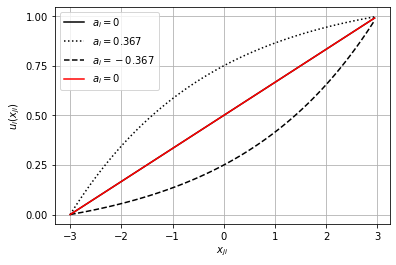

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.620, uy: 0.614, uz: 0.559, uz3: 0.55
Utility curve: 


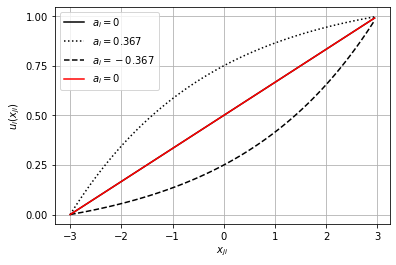

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.141, uy: 0.000, uz: 0.123, uz3: 0.12
Utility curve: 


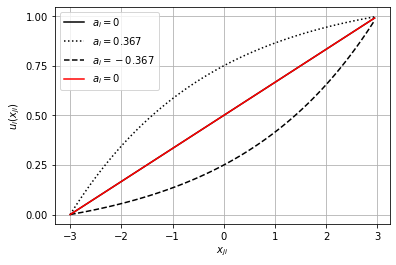

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.613, 0.62, 0.141]
y:  [0.672, 0.614, 0]
z:  [0.584, 0.559, 0.123]
z2:  [0.581, 0.554, 0.116]
Ux: 0.458, Uy: 0.429, Uz: 0.422, Uz2: 0.417

Alternative  4

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.300, uy: 0.144, uz: 0.319, uz3: 0.32
Utility curve: 


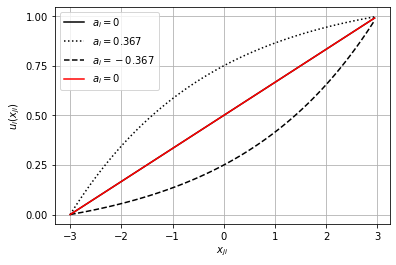

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.584, uy: 0.571, uz: 0.543, uz3: 0.54
Utility curve: 


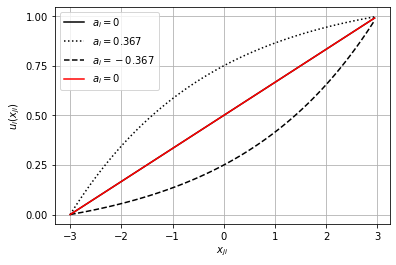

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.506, uy: 0.742, uz: 0.624, uz3: 0.63
Utility curve: 


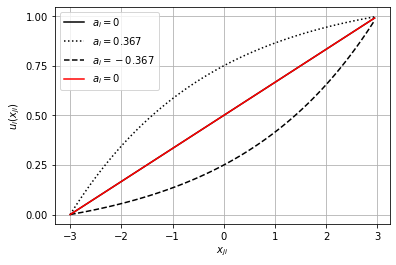

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.3, 0.584, 0.506]
y:  [0.144, 0.571, 0.742]
z:  [0.319, 0.543, 0.624]
z2:  [0.321, 0.538, 0.626]
Ux: 0.463, Uy: 0.486, Uz: 0.495, Uz2: 0.495

Alternative  0

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.286, uy: 0.120, uz: 0.308, uz3: 0.30
Utility curve: 


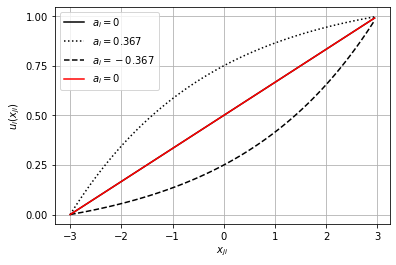

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.364, uy: 0.450, uz: 0.475, uz3: 0.47
Utility curve: 


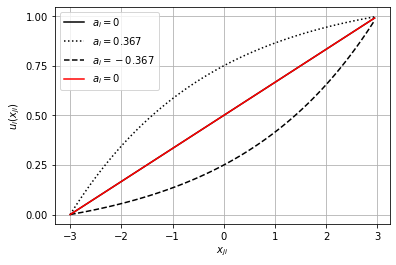

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.467, uy: 0.708, uz: 0.608, uz3: 0.60
Utility curve: 


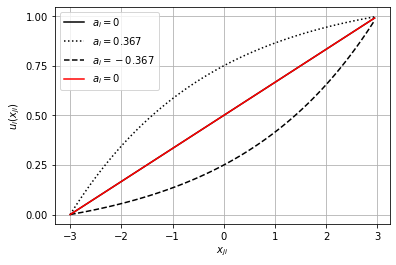

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.286, 0.364, 0.467]
y:  [0.12, 0.45, 0.708]
z:  [0.308, 0.475, 0.608]
z2:  [0.305, 0.471, 0.604]
Ux: 0.372, Uy: 0.426, Uz: 0.463, Uz2: 0.460

Alternative  1

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.282, uy: 0.612, uz: 0.554, uz3: 0.55
Utility curve: 


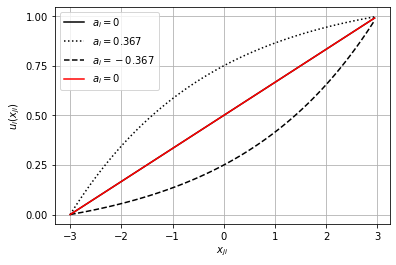

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.535, uy: 0.638, uz: 0.565, uz3: 0.57
Utility curve: 


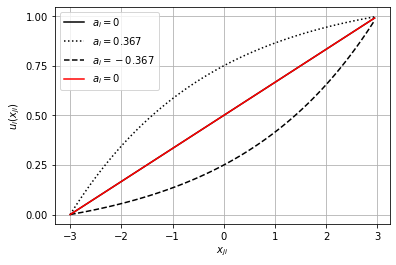

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.511, uy: 0.413, uz: 0.458, uz3: 0.45
Utility curve: 


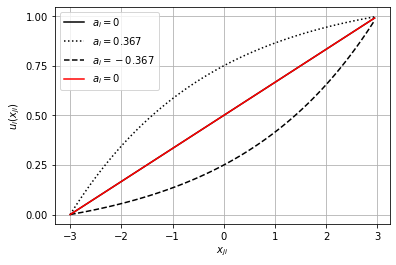

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.282, 0.535, 0.511]
y:  [0.612, 0.638, 0.413]
z:  [0.554, 0.565, 0.458]
z2:  [0.553, 0.575, 0.454]
Ux: 0.443, Uy: 0.555, Uz: 0.526, Uz2: 0.527

Alternative  2

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.331, uy: 0.091, uz: 0.295, uz3: 0.30
Utility curve: 


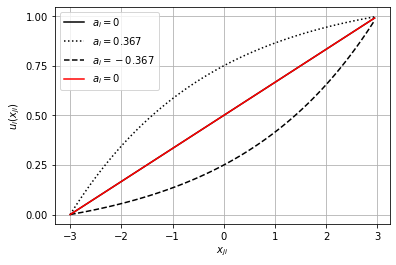

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.156, uy: 0.000, uz: 0.210, uz3: 0.21
Utility curve: 


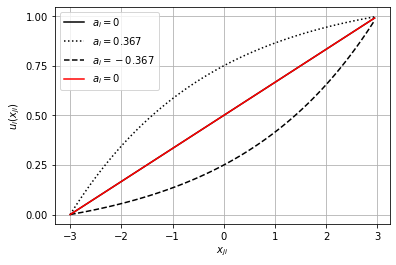

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.364, uy: 0.498, uz: 0.493, uz3: 0.51
Utility curve: 


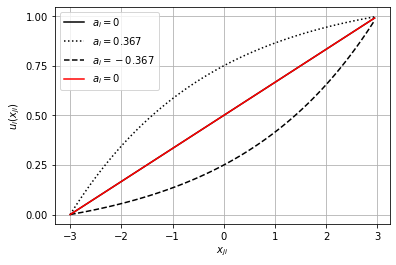

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.331, 0.156, 0.364]
y:  [0.091, 0, 0.498]
z:  [0.295, 0.21, 0.493]
z2:  [0.296, 0.212, 0.506]
Ux: 0.283, Uy: 0.196, Uz: 0.333, Uz2: 0.338

Alternative  3

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.482, uy: 0.390, uz: 0.443, uz3: 0.44
Utility curve: 


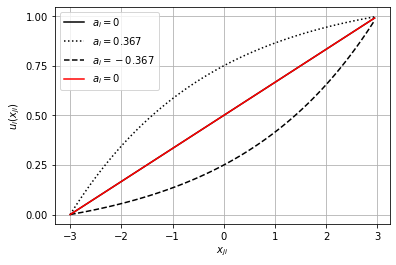

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.592, uy: 0.393, uz: 0.449, uz3: 0.44
Utility curve: 


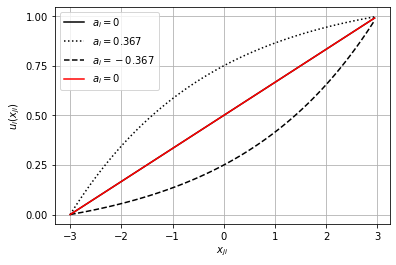

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.352, uy: 0.373, uz: 0.431, uz3: 0.44
Utility curve: 


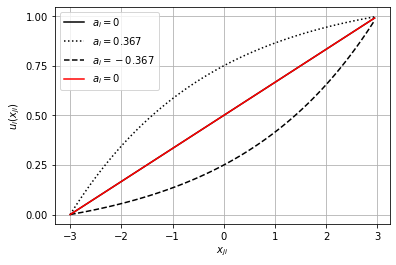

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.482, 0.592, 0.352]
y:  [0.39, 0.393, 0.373]
z:  [0.443, 0.449, 0.431]
z2:  [0.441, 0.44, 0.438]
Ux: 0.475, Uy: 0.386, Uz: 0.441, Uz2: 0.440

Alternative  4

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.543, uy: 0.633, uz: 0.570, uz3: 0.56
Utility curve: 


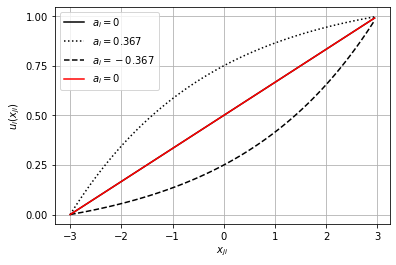

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.423, uy: 0.198, uz: 0.351, uz3: 0.34
Utility curve: 


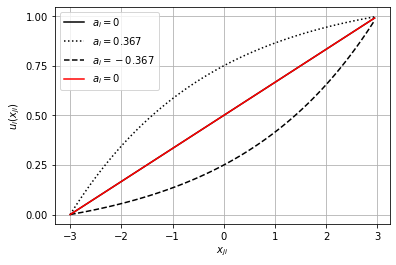

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.627, uy: 0.307, uz: 0.405, uz3: 0.40
Utility curve: 


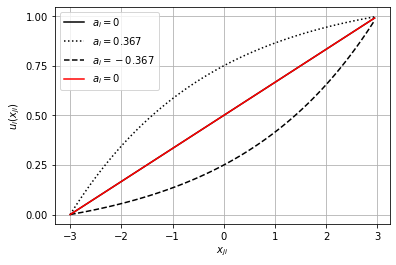

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.543, 0.423, 0.627]
y:  [0.633, 0.198, 0.307]
z:  [0.57, 0.351, 0.405]
z2:  [0.563, 0.345, 0.399]
Ux: 0.531, Uy: 0.379, Uz: 0.442, Uz2: 0.436

Alternative  0

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.516, uy: 0.495, uz: 0.503, uz3: 0.50
Utility curve: 


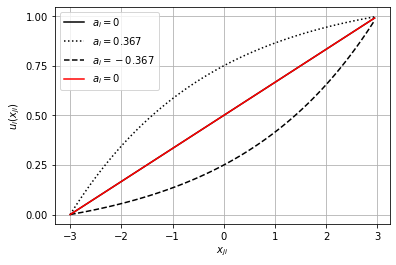

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.161, uy: 0.296, uz: 0.400, uz3: 0.40
Utility curve: 


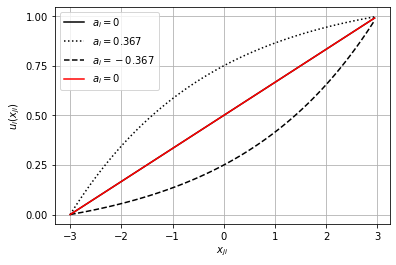

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.375, uy: 0.000, uz: 0.253, uz3: 0.25
Utility curve: 


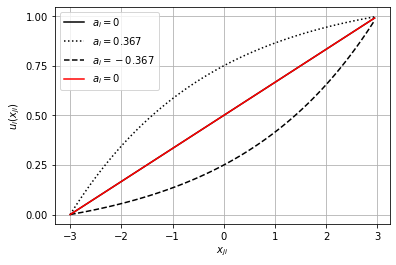

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.516, 0.161, 0.375]
y:  [0.495, 0.296, 0]
z:  [0.503, 0.4, 0.253]
z2:  [0.5, 0.4, 0.248]
Ux: 0.351, Uy: 0.264, Uz: 0.385, Uz2: 0.383

Alternative  1

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.315, uy: 0.345, uz: 0.421, uz3: 0.42
Utility curve: 


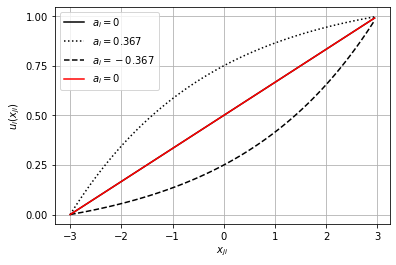

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.488, uy: 0.417, uz: 0.459, uz3: 0.46
Utility curve: 


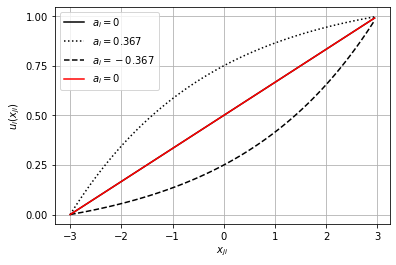

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.327, uy: 0.272, uz: 0.385, uz3: 0.38
Utility curve: 


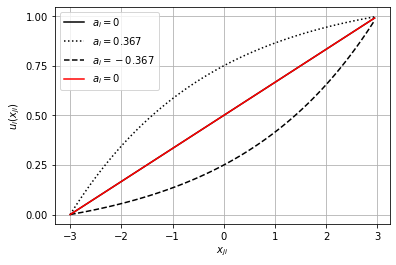

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.315, 0.488, 0.327]
y:  [0.345, 0.417, 0.272]
z:  [0.421, 0.459, 0.385]
z2:  [0.422, 0.456, 0.382]
Ux: 0.377, Uy: 0.345, Uz: 0.422, Uz2: 0.420

Alternative  2

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.479, uy: 0.000, uz: 0.245, uz3: 0.25
Utility curve: 


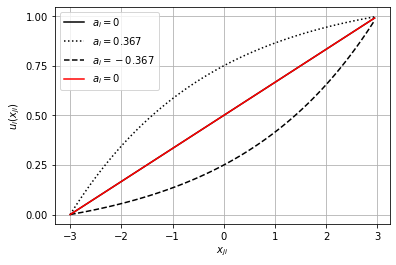

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.387, uy: 0.323, uz: 0.412, uz3: 0.42
Utility curve: 


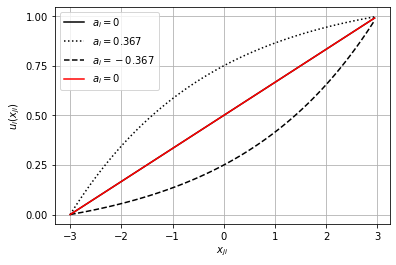

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.595, uy: 0.780, uz: 0.643, uz3: 0.65
Utility curve: 


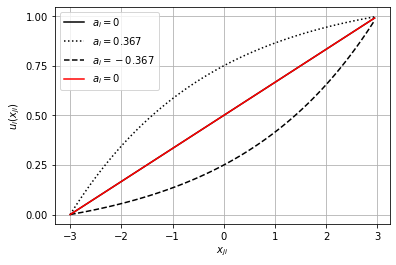

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.479, 0.387, 0.595]
y:  [0, 0.323, 0.78]
z:  [0.245, 0.412, 0.643]
z2:  [0.25, 0.417, 0.646]
Ux: 0.487, Uy: 0.368, Uz: 0.433, Uz2: 0.438

Alternative  3

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.677, uy: 0.780, uz: 0.645, uz3: 0.63
Utility curve: 


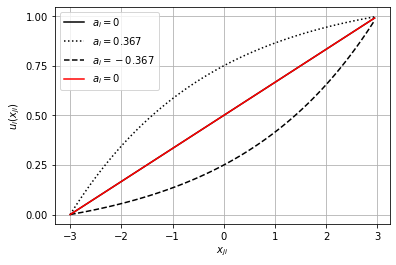

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.615, uy: 0.718, uz: 0.603, uz3: 0.61
Utility curve: 


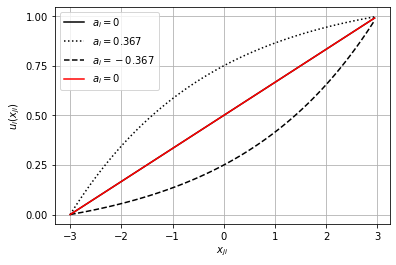

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.302, uy: 0.382, uz: 0.436, uz3: 0.44
Utility curve: 


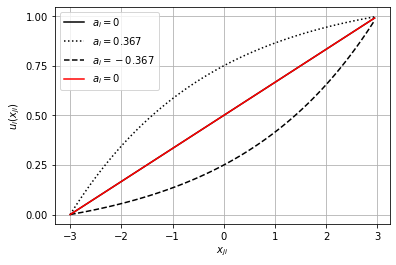

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.677, 0.615, 0.302]
y:  [0.78, 0.718, 0.382]
z:  [0.645, 0.603, 0.436]
z2:  [0.635, 0.612, 0.441]
Ux: 0.531, Uy: 0.627, Uz: 0.562, Uz2: 0.563

Alternative  4

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.640, uy: 0.808, uz: 0.655, uz3: 0.65
Utility curve: 


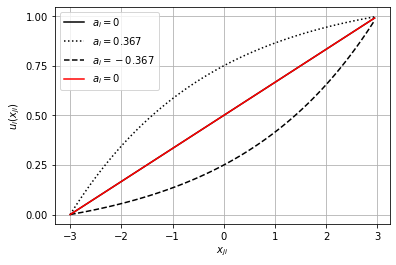

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.534, uy: 0.672, uz: 0.589, uz3: 0.58
Utility curve: 


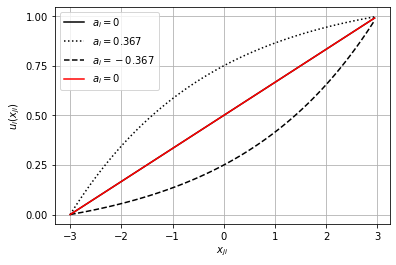

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.688, uy: 0.829, uz: 0.671, uz3: 0.67
Utility curve: 


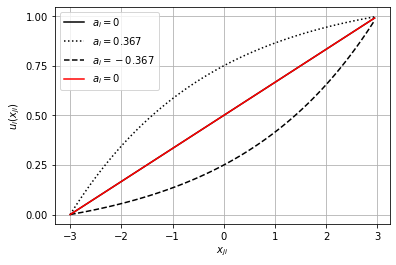

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.64, 0.534, 0.688]
y:  [0.808, 0.672, 0.829]
z:  [0.655, 0.589, 0.671]
z2:  [0.65, 0.584, 0.667]
Ux: 0.621, Uy: 0.770, Uz: 0.639, Uz2: 0.634

Alternative  0

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.508, uy: 0.724, uz: 0.606, uz3: 0.60
Utility curve: 


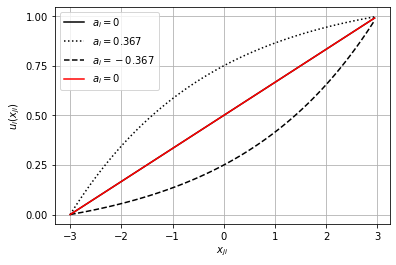

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.703, uy: 0.817, uz: 0.655, uz3: 0.65
Utility curve: 


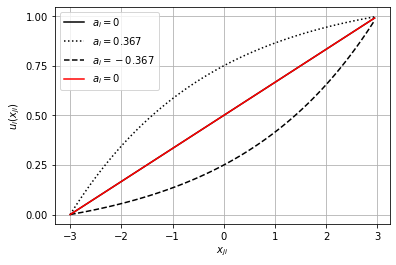

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.649, uy: 0.478, uz: 0.494, uz3: 0.49
Utility curve: 


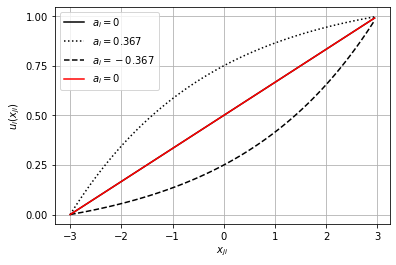

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.508, 0.703, 0.649]
y:  [0.724, 0.817, 0.478]
z:  [0.606, 0.655, 0.494]
z2:  [0.605, 0.654, 0.487]
Ux: 0.620, Uy: 0.673, Uz: 0.585, Uz2: 0.582

Alternative  1

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.557, uy: 0.553, uz: 0.528, uz3: 0.53
Utility curve: 


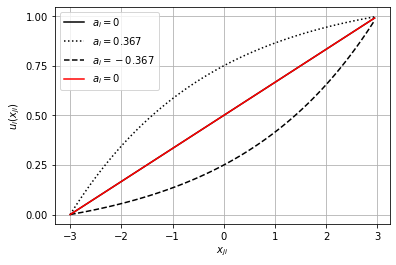

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.420, uy: 0.405, uz: 0.451, uz3: 0.45
Utility curve: 


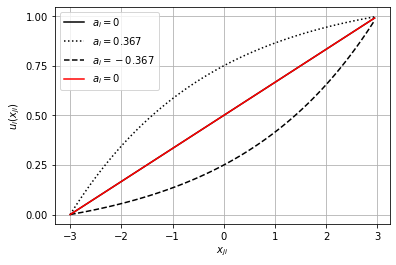

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.164, uy: 0.096, uz: 0.299, uz3: 0.30
Utility curve: 


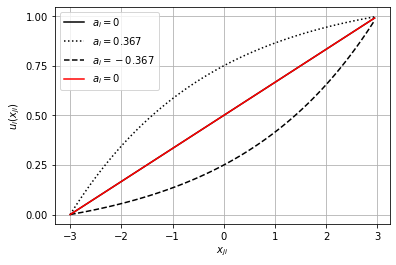

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.557, 0.42, 0.164]
y:  [0.553, 0.405, 0.096]
z:  [0.528, 0.451, 0.299]
z2:  [0.526, 0.454, 0.296]
Ux: 0.380, Uy: 0.352, Uz: 0.426, Uz2: 0.425

Alternative  2

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.475, uy: 0.566, uz: 0.530, uz3: 0.53
Utility curve: 


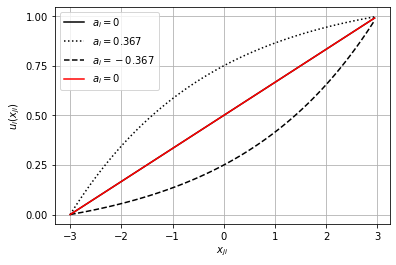

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.696, uy: 0.680, uz: 0.590, uz3: 0.58
Utility curve: 


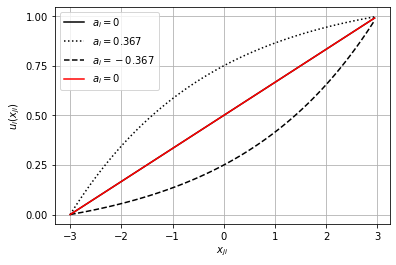

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.641, uy: 0.268, uz: 0.381, uz3: 0.38
Utility curve: 


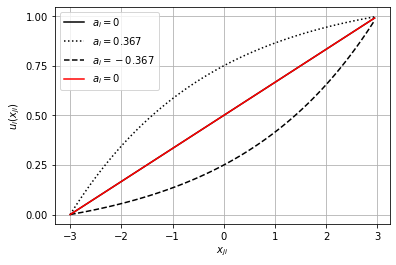

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.475, 0.696, 0.641]
y:  [0.566, 0.68, 0.268]
z:  [0.53, 0.59, 0.381]
z2:  [0.53, 0.585, 0.382]
Ux: 0.604, Uy: 0.505, Uz: 0.501, Uz2: 0.499

Alternative  3

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.212, uy: 0.411, uz: 0.455, uz3: 0.46
Utility curve: 


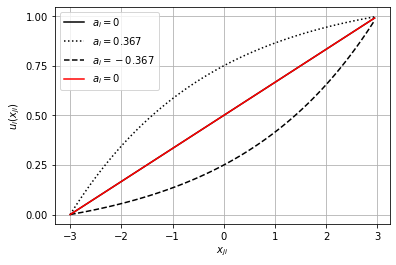

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.705, uy: 0.763, uz: 0.633, uz3: 0.64
Utility curve: 


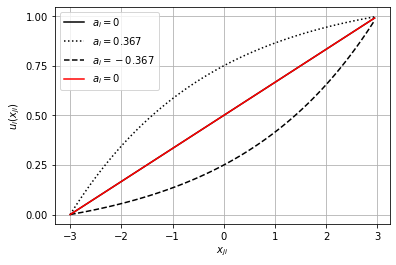

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.429, uy: 0.408, uz: 0.450, uz3: 0.45
Utility curve: 


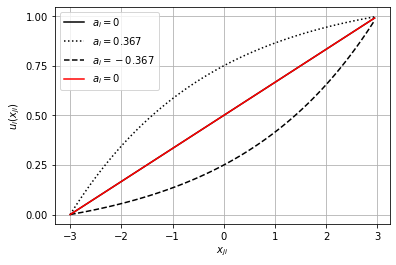

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.212, 0.705, 0.429]
y:  [0.411, 0.763, 0.408]
z:  [0.455, 0.633, 0.45]
z2:  [0.456, 0.636, 0.453]
Ux: 0.449, Uy: 0.527, Uz: 0.513, Uz2: 0.515

Alternative  4

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.360, uy: 0.289, uz: 0.400, uz3: 0.40
Utility curve: 


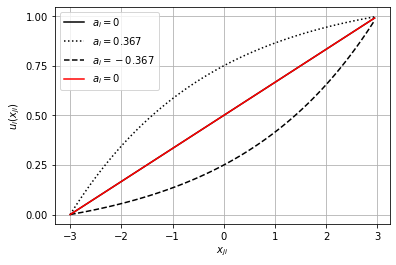

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.344, uy: 0.410, uz: 0.451, uz3: 0.45
Utility curve: 


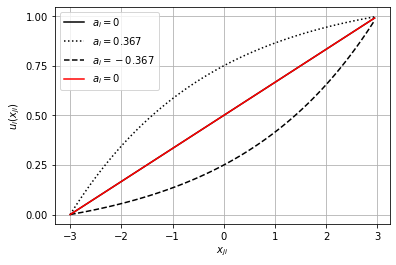

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.204, uy: 0.238, uz: 0.371, uz3: 0.36
Utility curve: 


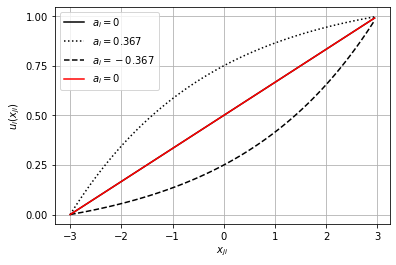

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.36, 0.344, 0.204]
y:  [0.289, 0.41, 0.238]
z:  [0.4, 0.451, 0.371]
z2:  [0.395, 0.454, 0.364]
Ux: 0.303, Uy: 0.313, Uz: 0.407, Uz2: 0.405

Alternative  0

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.574, uy: 1.000, uz: 0.763, uz3: 0.78
Utility curve: 


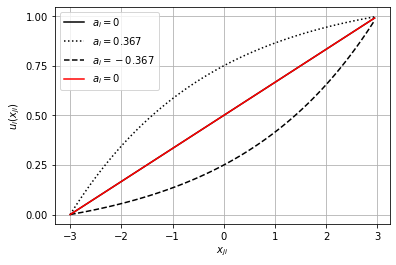

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.466, uy: 0.573, uz: 0.538, uz3: 0.55
Utility curve: 


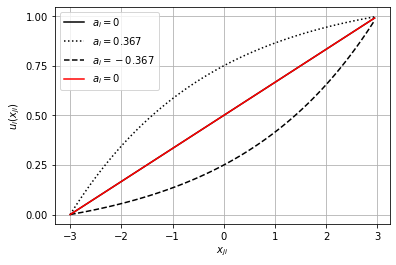

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.631, uy: 0.672, uz: 0.591, uz3: 0.58
Utility curve: 


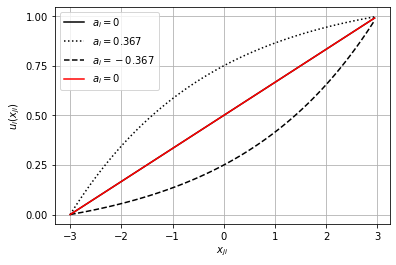

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.574, 0.466, 0.631]
y:  [1, 0.573, 0.672]
z:  [0.763, 0.538, 0.591]
z2:  [0.775, 0.545, 0.583]
Ux: 0.557, Uy: 0.748, Uz: 0.631, Uz2: 0.634

Alternative  1

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.686, uy: 0.718, uz: 0.611, uz3: 0.61
Utility curve: 


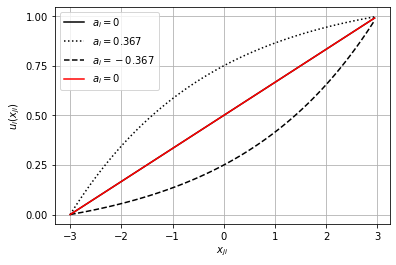

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.631, uy: 0.560, uz: 0.533, uz3: 0.53
Utility curve: 


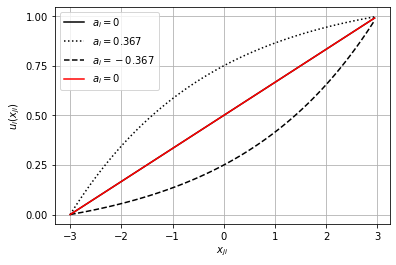

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.385, uy: 0.000, uz: 0.214, uz3: 0.21
Utility curve: 


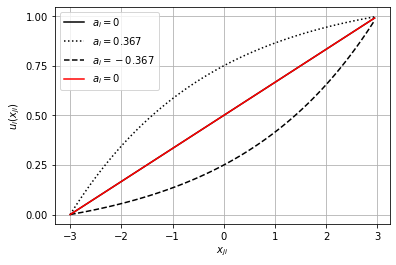

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.686, 0.631, 0.385]
y:  [0.718, 0.56, 0]
z:  [0.611, 0.533, 0.214]
z2:  [0.607, 0.534, 0.21]
Ux: 0.567, Uy: 0.426, Uz: 0.453, Uz2: 0.450

Alternative  2

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.634, uy: 0.543, uz: 0.519, uz3: 0.52
Utility curve: 


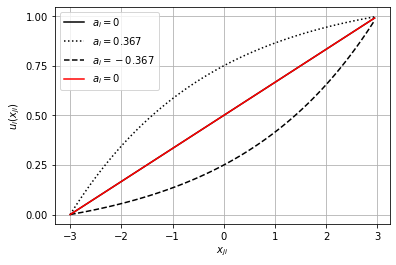

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.348, uy: 0.000, uz: 0.202, uz3: 0.20
Utility curve: 


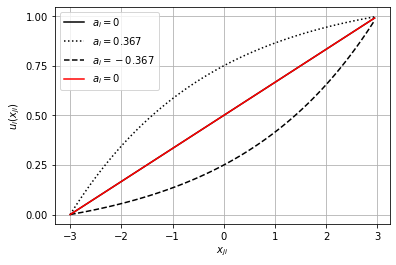

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.749, uy: 0.731, uz: 0.620, uz3: 0.61
Utility curve: 


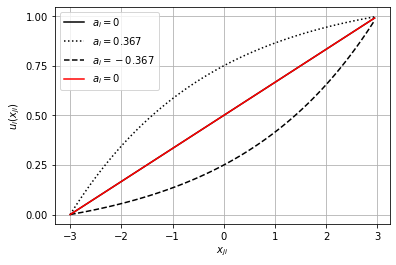

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.634, 0.348, 0.749]
y:  [0.543, 0, 0.731]
z:  [0.519, 0.202, 0.62]
z2:  [0.517, 0.202, 0.615]
Ux: 0.577, Uy: 0.425, Uz: 0.447, Uz2: 0.444

Alternative  3

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.444, uy: 0.499, uz: 0.501, uz3: 0.50
Utility curve: 


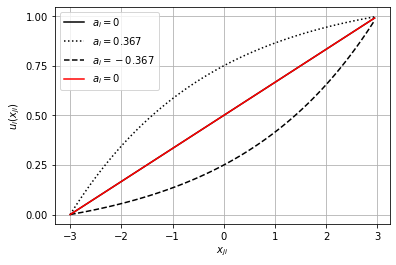

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.482, uy: 0.457, uz: 0.481, uz3: 0.48
Utility curve: 


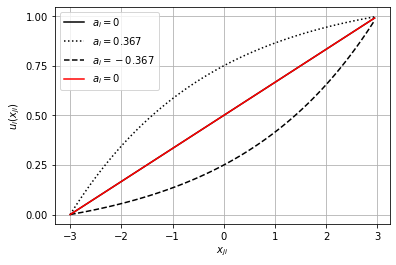

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.388, uy: 0.162, uz: 0.328, uz3: 0.33
Utility curve: 


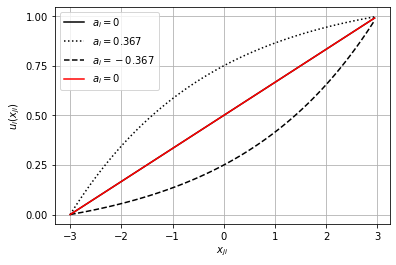

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.444, 0.482, 0.388]
y:  [0.499, 0.457, 0.162]
z:  [0.501, 0.481, 0.328]
z2:  [0.502, 0.483, 0.332]
Ux: 0.438, Uy: 0.373, Uz: 0.437, Uz2: 0.439

Alternative  4

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.368, uy: 0.348, uz: 0.419, uz3: 0.42
Utility curve: 


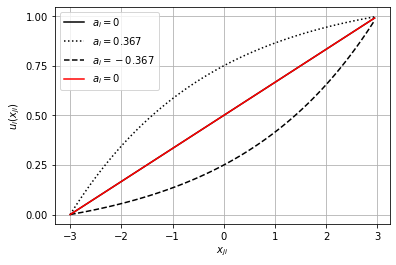

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.519, uy: 0.478, uz: 0.490, uz3: 0.49
Utility curve: 


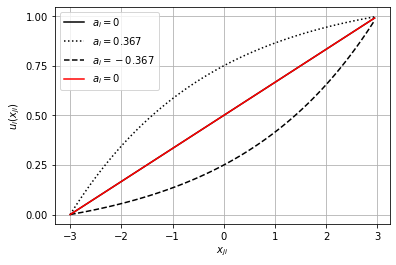

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.567, uy: 0.471, uz: 0.488, uz3: 0.48
Utility curve: 


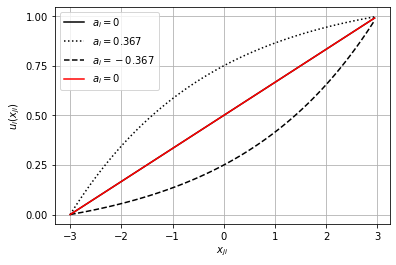

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.368, 0.519, 0.567]
y:  [0.348, 0.478, 0.471]
z:  [0.419, 0.49, 0.488]
z2:  [0.421, 0.488, 0.485]
Ux: 0.485, Uy: 0.432, Uz: 0.465, Uz2: 0.464

Alternative  0

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.584, uy: 0.584, uz: 0.541, uz3: 0.54
Utility curve: 


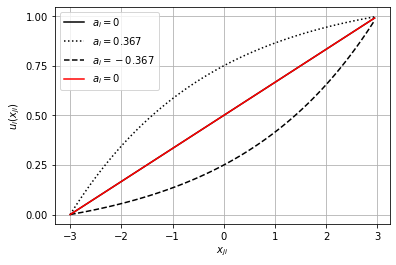

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.397, uy: 0.000, uz: 0.231, uz3: 0.22
Utility curve: 


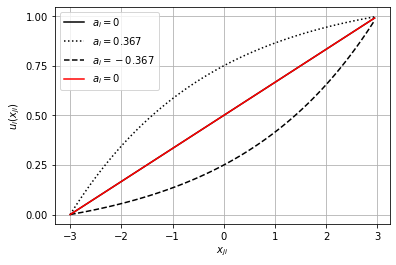

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.541, uy: 0.310, uz: 0.407, uz3: 0.40
Utility curve: 


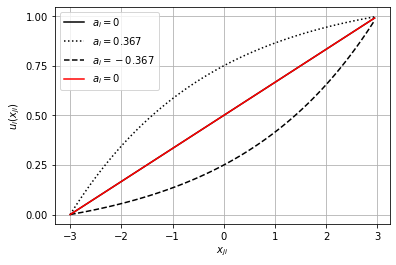

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.584, 0.397, 0.541]
y:  [0.584, 0, 0.31]
z:  [0.541, 0.231, 0.407]
z2:  [0.543, 0.222, 0.4]
Ux: 0.507, Uy: 0.298, Uz: 0.393, Uz2: 0.388

Alternative  1

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.304, uy: 0.295, uz: 0.401, uz3: 0.40
Utility curve: 


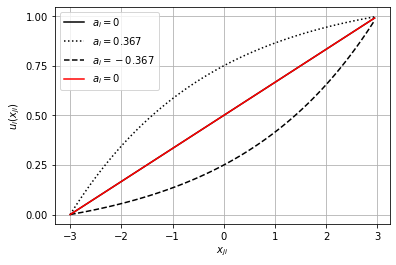

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.382, uy: 0.492, uz: 0.495, uz3: 0.49
Utility curve: 


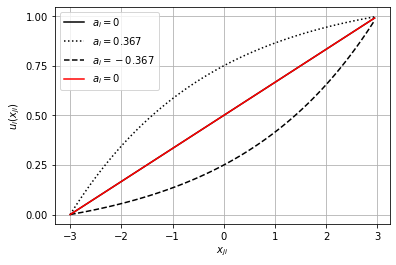

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.712, uy: 0.625, uz: 0.567, uz3: 0.56
Utility curve: 


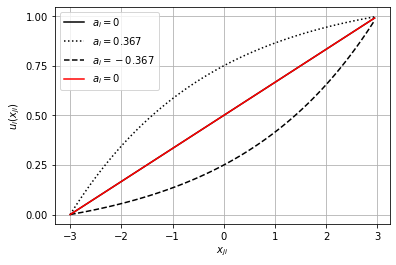

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.304, 0.382, 0.712]
y:  [0.295, 0.492, 0.625]
z:  [0.401, 0.495, 0.567]
z2:  [0.398, 0.495, 0.556]
Ux: 0.466, Uy: 0.471, Uz: 0.488, Uz2: 0.483

Alternative  2

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.240, uy: 0.272, uz: 0.382, uz3: 0.38
Utility curve: 


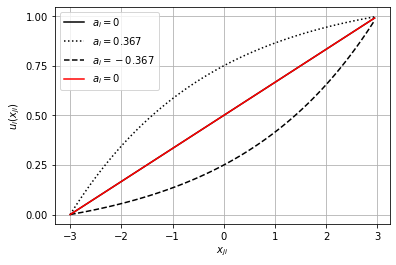

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.654, uy: 0.626, uz: 0.560, uz3: 0.56
Utility curve: 


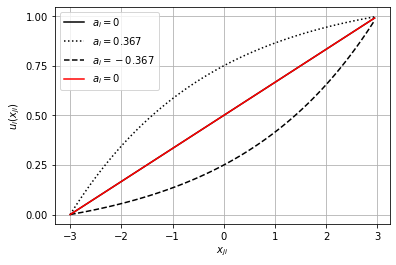

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.612, uy: 0.489, uz: 0.503, uz3: 0.49
Utility curve: 


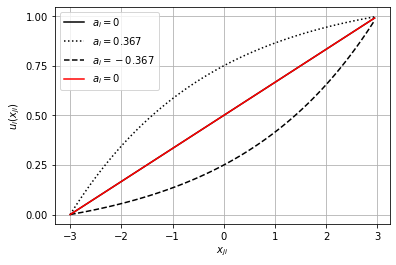

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.24, 0.654, 0.612]
y:  [0.272, 0.626, 0.489]
z:  [0.382, 0.56, 0.503]
z2:  [0.38, 0.557, 0.49]
Ux: 0.502, Uy: 0.463, Uz: 0.482, Uz2: 0.476

Alternative  3

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.948, uy: 1.000, uz: 0.794, uz3: 0.80
Utility curve: 


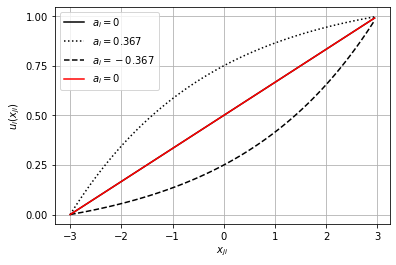

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.492, uy: 0.493, uz: 0.499, uz3: 0.50
Utility curve: 


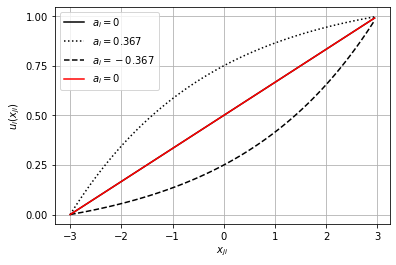

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.715, uy: 0.821, uz: 0.658, uz3: 0.66
Utility curve: 


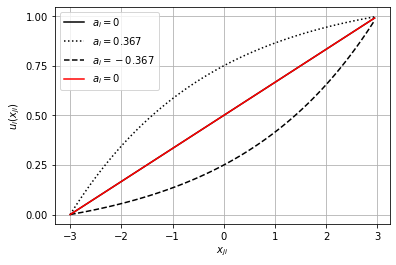

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.948, 0.492, 0.715]
y:  [1, 0.493, 0.821]
z:  [0.794, 0.499, 0.658]
z2:  [0.799, 0.502, 0.658]
Ux: 0.718, Uy: 0.771, Uz: 0.650, Uz2: 0.653

Alternative  4

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.473, uy: 0.469, uz: 0.491, uz3: 0.48
Utility curve: 


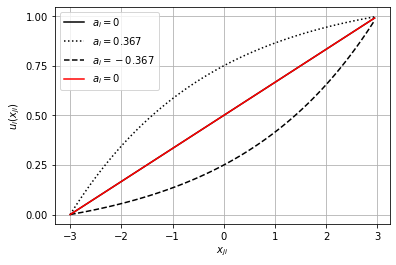

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.353, uy: 0.365, uz: 0.429, uz3: 0.42
Utility curve: 


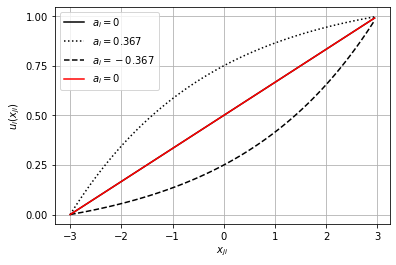

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.419, uy: 0.586, uz: 0.540, uz3: 0.55
Utility curve: 


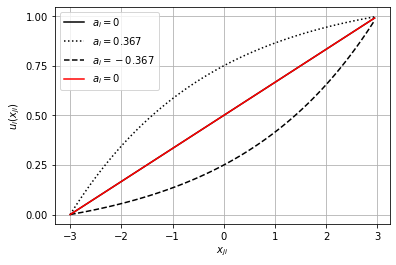

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.473, 0.353, 0.419]
y:  [0.469, 0.365, 0.586]
z:  [0.491, 0.429, 0.54]
z2:  [0.482, 0.422, 0.546]
Ux: 0.415, Uy: 0.473, Uz: 0.487, Uz2: 0.483

Alternative  0

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.276, uy: 0.189, uz: 0.343, uz3: 0.35
Utility curve: 


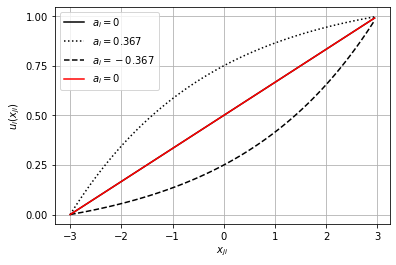

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.612, uy: 0.575, uz: 0.535, uz3: 0.54
Utility curve: 


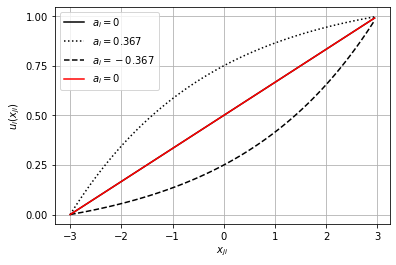

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.408, uy: 0.662, uz: 0.583, uz3: 0.58
Utility curve: 


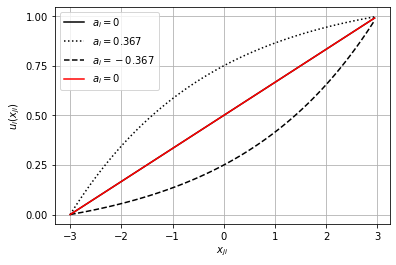

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.276, 0.612, 0.408]
y:  [0.189, 0.575, 0.662]
z:  [0.343, 0.535, 0.583]
z2:  [0.347, 0.537, 0.581]
Ux: 0.432, Uy: 0.475, Uz: 0.487, Uz2: 0.488

Alternative  1

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.545, uy: 0.622, uz: 0.566, uz3: 0.56
Utility curve: 


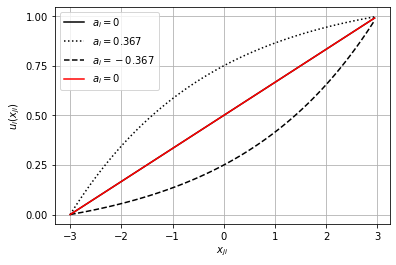

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.737, uy: 0.864, uz: 0.687, uz3: 0.68
Utility curve: 


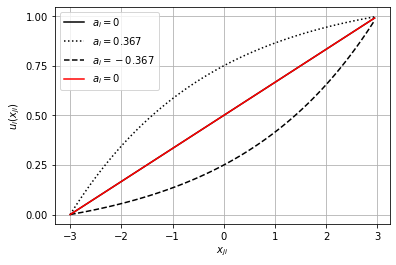

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.760, uy: 0.840, uz: 0.666, uz3: 0.67
Utility curve: 


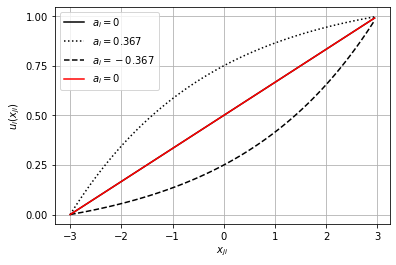

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.545, 0.737, 0.76]
y:  [0.622, 0.864, 0.84]
z:  [0.566, 0.687, 0.666]
z2:  [0.562, 0.684, 0.665]
Ux: 0.681, Uy: 0.775, Uz: 0.640, Uz2: 0.637

Alternative  2

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.432, uy: 0.411, uz: 0.460, uz3: 0.46
Utility curve: 


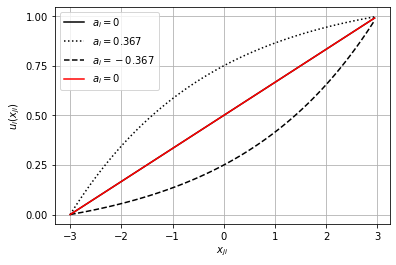

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.635, uy: 0.545, uz: 0.523, uz3: 0.53
Utility curve: 


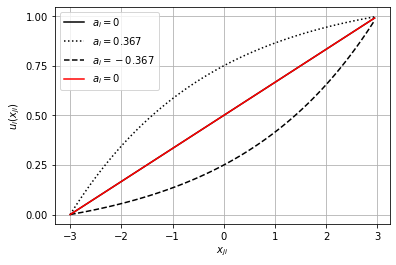

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.617, uy: 0.294, uz: 0.396, uz3: 0.40
Utility curve: 


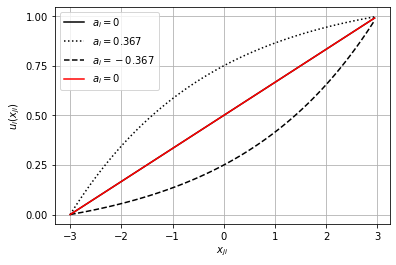

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.432, 0.635, 0.617]
y:  [0.411, 0.545, 0.294]
z:  [0.46, 0.523, 0.396]
z2:  [0.457, 0.525, 0.398]
Ux: 0.561, Uy: 0.417, Uz: 0.460, Uz2: 0.460

Alternative  3

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.517, uy: 0.751, uz: 0.636, uz3: 0.63
Utility curve: 


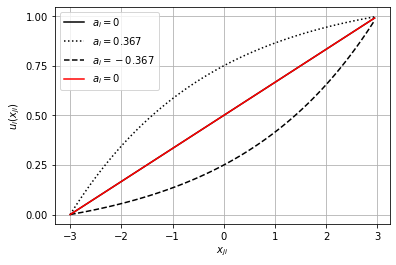

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.763, uy: 1.000, uz: 0.784, uz3: 0.79
Utility curve: 


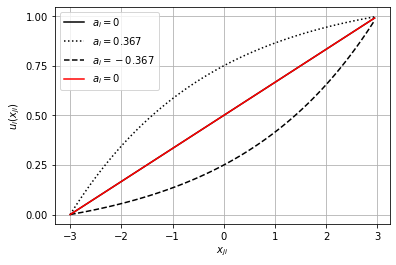

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.794, uy: 0.810, uz: 0.656, uz3: 0.65
Utility curve: 


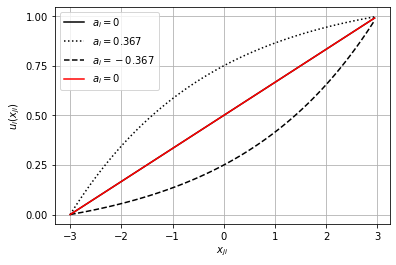

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.517, 0.763, 0.794]
y:  [0.751, 1, 0.81]
z:  [0.636, 0.784, 0.656]
z2:  [0.625, 0.787, 0.651]
Ux: 0.691, Uy: 0.854, Uz: 0.692, Uz2: 0.688

Alternative  4

Attribute settings:
Attribute  0
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.471, uy: 0.392, uz: 0.446, uz3: 0.45
Utility curve: 


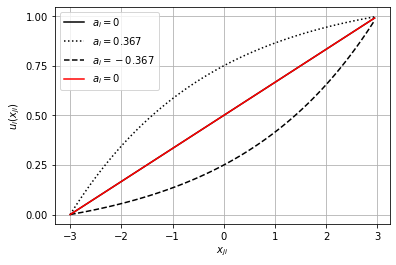

None
Attribute  1
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.407, uy: 0.622, uz: 0.561, uz3: 0.56
Utility curve: 


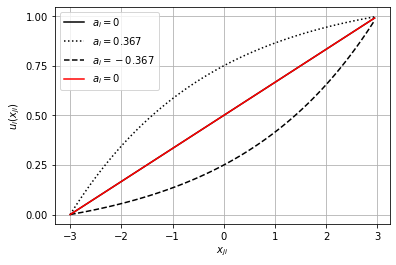

None
Attribute  2
Mean:  0
Std:  1
Risk parameter a:  0
Estimation uncertainty:  1
ux: 0.707, uy: 0.846, uz: 0.673, uz3: 0.67
Utility curve: 


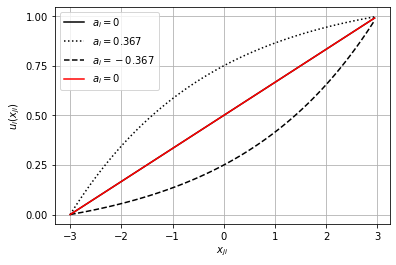

None
Number of attributes:  3
Attribute weights:  [0.333, 0.333, 0.333]
x:  [0.471, 0.407, 0.707]
y:  [0.392, 0.622, 0.846]
z:  [0.446, 0.561, 0.673]
z2:  [0.448, 0.563, 0.672]
Ux: 0.528, Uy: 0.620, Uz: 0.560, Uz2: 0.561

Duration: 0:00:39.646513


In [65]:
s.run(10)

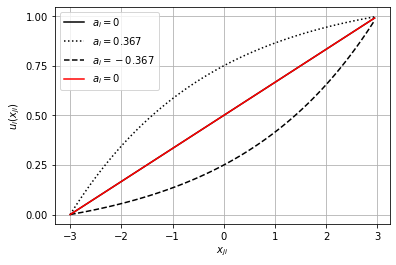

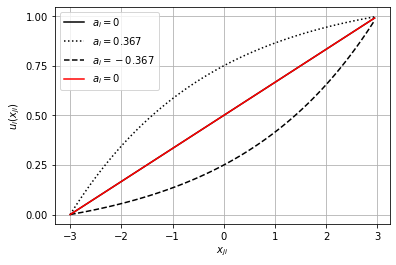

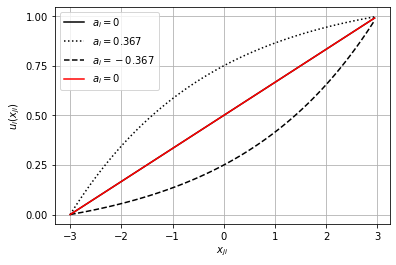

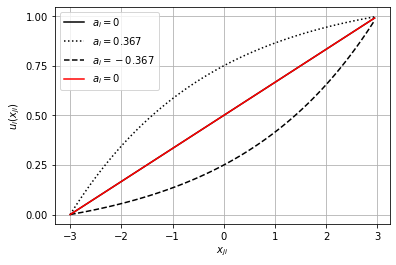

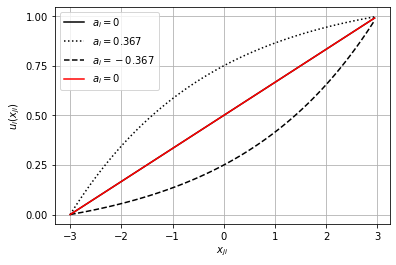

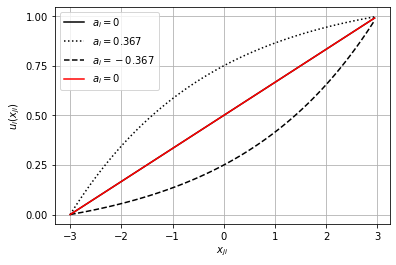

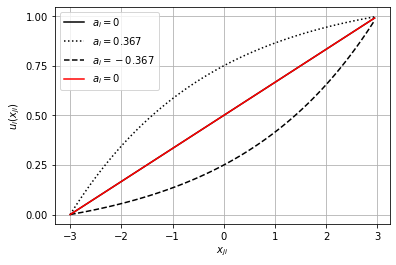

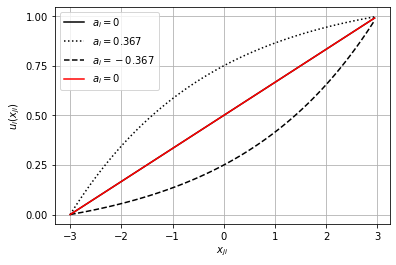

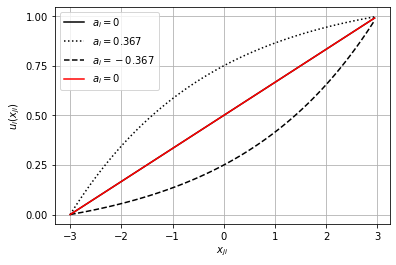

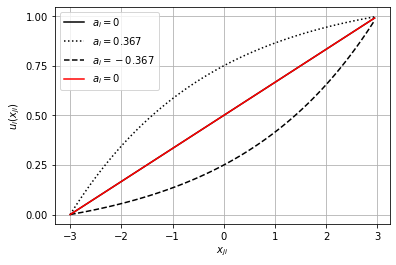

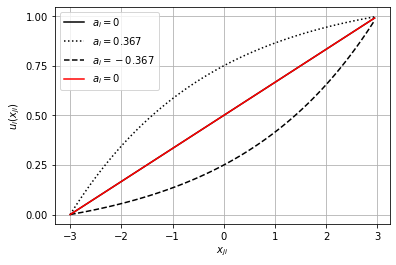

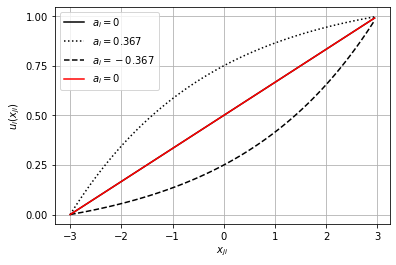

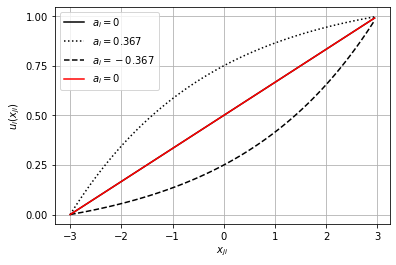

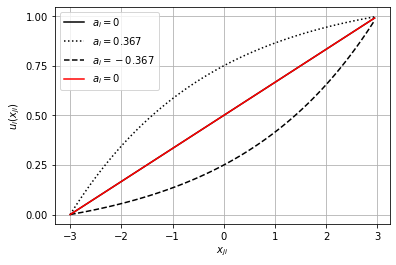

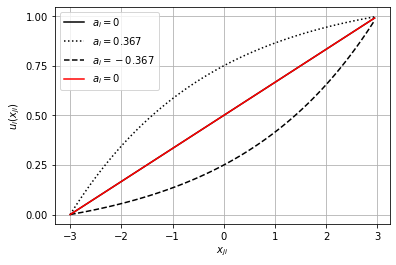

In [66]:
s.save_output("test")

In [90]:
d= pd.read_csv("test.csv")

In [91]:
d

Unnamed: 0     pds_y     pds_z    pds_z2  eu_yz  eu_yz2  eu_zz2  toc_y  \
0           0 -0.113816  0.021473  0.027466    0.0     0.0     0.0   True   
1           1 -0.147413 -0.078955 -0.080850    0.0     0.0     0.0  False   
2           2 -0.144810 -0.018945 -0.014720    0.0     0.0     0.0   True   
3           3  0.162796  0.213125  0.217373    0.0     0.0     0.0   True   
4           4 -0.201562 -0.157253 -0.160207    0.0     0.0     0.0  False   
5           5 -0.193234 -0.027547 -0.020261    0.0     0.0     0.0   True   
6           6 -0.078571  0.059980  0.065048    0.0     0.0     0.0   True   
7           7 -0.255486 -0.116965 -0.121868    0.0     0.0     0.0  False   
8           8 -0.068404  0.104883  0.100001    0.0     0.0     0.0   True   
9           9 -0.190426 -0.001523  0.005248    0.0     0.0     0.0   True   

   toc_z  toc_z2  
0   True    True  
1  False   False  
2   True    True  
3   True    True  
4  False   False  
5   True    True  
6   True    True  
7  False   False  
8   True    True  
9   True    True